# Reinforcement Learning Agent for Statistical Arbitrage

This notebook demonstrates how to configure and train a reinforcement learning agent for statistical arbitrage using a snapshot model. The agent will learn to identify and exploit statistical arbitrage opportunities in financial markets.

## Install Packages

The following libraries are required for this notebook. If you haven't installed them yet, you can do so using running the cell below or by using pip install in your terminal.

In [1]:
# Uncomment and install packages once
# %pip -q install -U numpy pandas pyarrow gdown gymnasium stable-baselines3 torch matplotlib tensorboard

## Import Libraries

In [2]:
import os
import json
from gdown import download
import math
import random
import pytz

from datetime import datetime

from typing import Tuple, Set, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from IPython.display import display

# Reinforcement Learning
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback, CallbackList
from stable_baselines3.common.monitor import Monitor

# Deep Learning
import torch

from config import CONFIG

print("Imports complete.")

Imports complete.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## Helper Functions

In [3]:
# set annualization factors for different timeframes
ANNUALIZATION = {"1m":365*24*60,
                 "5m":365*24*12,
                 "15m":365*24*4,
                 "1h":365*24,
                 "1d":365}

# create directory if it doesn't already exist
def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

## Set Computation Device

This section sets the computation device for training the model. It checks if a GPU is available and sets it as the device; otherwise, it defaults to CPU.

In [4]:
# run on cuda GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")

# run on Apple Silicon GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available. Using Apple Silicon GPU.")

# run on CPU (slow)
else:
    device = torch.device("cpu")
    print("CUDA and MPS are not available. Using CPU.")

MPS is available. Using Apple Silicon GPU.


## Set Seeds

This section sets the random seeds for various libraries to ensure that the results are reproducible.

Note: It is good practice to type (set data types) for function and method parameters for better code maintainability.

In [5]:
def set_all_seeds(seed: int = 42):
    random.seed(seed) # seed for random module
    np.random.seed(seed) # seed for numpy module
    try:
        torch.manual_seed(seed) # seed for torch module
        if torch.cuda.is_available(): # seed for CUDA device
            torch.cuda.manual_seed_all(seed)
        elif torch.backends.mps.is_available(): # seed for Apple Silicon device
            torch.backends.mps.manual_seed_all(seed)
    except Exception:
        pass

set_all_seeds(CONFIG["ENV"]["seed"]) # set all seeds for reproducibility

## Download Feature Data

In this section, we retrieve the .csv file created during feature engineering.

In [6]:
def download_file(file_name: str, file_id: str, out_dir: str):
    ensure_dir(out_dir)

    out_path = os.path.join(out_dir, f"{file_name}.csv")  # full output path

    if os.path.exists(out_path):
        print(f"Skipping download. File {file_name} already exists in cache.")
        return

    try:
        print(f"Downloading {file_name} -> {out_path}")
        url = f"https://drive.google.com/uc?id={file_id}"
        success = download(url, out_path, quiet=False, use_cookies=False, verify=True)
        print("Download complete.")
        return success
    except Exception as e:
        print(f"Download attempt failed for {file_name}. Error: {str(e)}")
    
# donwload features
file_name = CONFIG["DATA"]["features"]["file_name"]
file_id = CONFIG["DATA"]["features"]["file_id"]
cache_dir = CONFIG["DATA"]["cache_dir"]

success = download_file(file_name, file_id, cache_dir)

Skipping download. File bin_futures_full_features already exists in cache.


## Load Feature Data

Once the data is downloaded, this section loads the data into a pandas DataFrame for later processing.

In [7]:
def load_csv_to_df(
    path: str,
    sep: str = ",",
    timestamp_index_col: str | None = "datetime",
    encoding: str = "utf-8-sig",
    **read_csv_kwargs,
) -> pd.DataFrame:
    """
    Load a CSV into a pandas DataFrame.

    Parameters
    ----------
    path : str
        Filesystem path to the CSV.
    parse_timestamp_col : str | None
        If provided and present in the CSV, this column will be parsed to datetime.
        Set to None to skip datetime parsing.
    **read_csv_kwargs :
        Extra arguments passed to `pd.read_csv` (e.g., sep, dtype, usecols).

    Returns
    -------
    pd.DataFrame
    """

    # Parse header-only to check for timestamp col presence
    head = pd.read_csv(path, sep=sep, encoding=encoding, nrows=0)
    if timestamp_index_col and timestamp_index_col in head.columns:
        read_csv_kwargs = {
            **read_csv_kwargs,
            "parse_dates": [timestamp_index_col],
        }

    df = pd.read_csv(path, sep=sep, encoding=encoding, engine="pyarrow", **read_csv_kwargs)

    df = df.set_index("datetime")

    return df


# load features
file_name = CONFIG["DATA"]["features"]["file_name"]
cache_dir = CONFIG["DATA"]["cache_dir"]
index = CONFIG["DATA"]["features"]["index"]
sep = CONFIG["DATA"]["features"].get("seperator", ",")
file_path = os.path.join(cache_dir, f"{file_name}.csv")
features_df = load_csv_to_df(file_path, sep, timestamp_index_col=index)

# print dataframe info
print("Features DataFrame Info:")
print(features_df.info())

Features DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2024-05-01 00:00:00 to 2025-04-30 23:59:00
Columns: 789 entries, AAVE_close to XRP_fundingMinutesLeft
dtypes: float64(763), int64(25), object(1)
memory usage: 3.1+ GB
None


## Identify Feature Structure

In [8]:
def identify_assets_features_pairs(
    df: pd.DataFrame,
    single_asset_format: str,
    pair_feature_format: str,
) -> tuple[list[str], list[str], list[str], list[tuple[str, str]]]:
    """
    Returns distinct
      1. assets
      2. single-asset feature names (ARB_closeUpperShadow → closeUpperShadow)
      3. pair feature names (ARB_ETH_spreadNorm → spreadNorm)
      4. unordered asset pairs
    """

    def format_to_regex(fmt: str) -> re.Pattern:
        escaped = re.escape(fmt)

        def repl(match: re.Match[str]) -> str:
            name = match.group(1)
            char_class = r"[A-Za-z0-9_]+" if "FEATURE" in name.upper() else r"[A-Za-z0-9]+"
            return f"(?P<{name}>{char_class})"

        escaped = re.sub(r"\\\{(\w+)\\\}", repl, escaped)
        return re.compile(f"^{escaped}$")

    single_asset_pattern = format_to_regex(single_asset_format)
    pair_feature_pattern = format_to_regex(pair_feature_format)
    generic_single_pattern = re.compile(r"^(?P<ASSET>[A-Za-z0-9]+)_(?P<FEATURE>[A-Za-z0-9_]+)$")

    assets: Set[str] = set()
    single_features: Set[str] = set()
    pair_features: Set[str] = set()
    pairs: Set[Tuple[str, str]] = set()

    literal_feature = None
    if "{FEATURE}" not in single_asset_format:
        literal_feature = single_asset_format.replace("{ASSET}", "").lstrip("_")

    skip_cols = {"timestamp", "datetime", "date"}

    for col in df.columns:
        if col in skip_cols:
            continue

        match_pair = pair_feature_pattern.match(col)
        if match_pair:
            a1, a2, feat = match_pair.group("ASSET1"), match_pair.group("ASSET2"), match_pair.group("FEATURE")
            assets.update((a1, a2))
            pairs.add(tuple(sorted((a1, a2))))
            pair_features.add(feat)
            continue

        match_single = single_asset_pattern.match(col)
        if match_single:
            asset = match_single.group("ASSET")
            assets.add(asset)
            feat = match_single.groupdict().get("FEATURE") or literal_feature
            if feat:
                single_features.add(feat)
            continue

        match_generic = generic_single_pattern.match(col)
        if match_generic:
            asset, feat = match_generic.group("ASSET"), match_generic.group("FEATURE")
            assets.add(asset)
            single_features.add(feat)
            continue

    return (
        sorted(assets),
        sorted(single_features),
        sorted(pair_features),
        sorted(pairs),
    )

# identify assets, features, and asset pairs
single_asset_format = CONFIG["DATA"]["asset_price_format"]
pair_feature_format = CONFIG["DATA"]["pair_feature_format"]
assets, single_asset_features, pair_features, asset_pairs = identify_assets_features_pairs(
    features_df,
    CONFIG["DATA"]["asset_price_format"],
    CONFIG["DATA"]["pair_feature_format"],
)

print(f"Identified {len(assets)} assets: {assets}")
print(f"Identified {len(single_asset_features)} single-asset features: {single_asset_features}")
print(f"Identified {len(pair_features)} pair features: {pair_features}")
print(f"Identified {len(asset_pairs)} asset pairs: {asset_pairs}")

Identified 25 assets: ['AAVE', 'ADA', 'APT', 'ARB', 'ATOM', 'AVAX', 'BCH', 'BNB', 'BTC', 'DOGE', 'DOT', 'ENA', 'ETC', 'ETH', 'HBAR', 'LINK', 'LTC', 'NEAR', 'SUI', 'TON', 'TRX', 'UNI', 'WLD', 'XLM', 'XRP']
Identified 12 single-asset features: ['close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow', 'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow', 'funding', 'fundingMinutesLeft']
Identified 8 pair features: ['alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman', 'spreadNormMa', 'spreadNormVol']
Identified 61 asset pairs: [('AAVE', 'SUI'), ('AAVE', 'TRX'), ('ADA', 'BTC'), ('ADA', 'DOGE'), ('ADA', 'HBAR'), ('ADA', 'LTC'), ('ADA', 'SUI'), ('ADA', 'XLM'), ('ADA', 'XRP'), ('APT', 'AVAX'), ('ARB', 'ATOM'), ('ARB', 'AVAX'), ('ARB', 'DOT'), ('ARB', 'ETC'), ('ARB', 'ETH'), ('ARB', 'NEAR'), ('ARB', 'WLD'), ('ATOM', 'BCH'), ('ATOM', 'DOT'), ('ATOM', 'ENA'), ('ATOM', 'ETC'), ('AVAX', 'BCH'), ('AVAX', 'DOT'), ('AVAX', 'ETC'), ('AVAX', 'UNI'), ('

## Build Time Intervals

In [9]:
def build_time_intervals(
    df: pd.DataFrame,
    window: pd.Timedelta | str,
    step: Optional[pd.Timedelta | str] = None,
    timestamp_col: str = "datetime",
    include_last_partial: bool = False,
) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    """
    Return fixed-length time intervals over the DataFrame's time span.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a datetime-like 'timestamp' column or have a DatetimeIndex.
    window : pd.Timedelta | str
        Size of each window, e.g. '2D', '60min', '15T'.
    step : pd.Timedelta | str | None
        Step between consecutive window starts. Defaults to `window` (non-overlapping).
        Use a smaller step than `window` for sliding/overlapping windows.
    timestamp_col : str
        Name of the timestamp column (ignored if index is a DatetimeIndex).
    include_last_partial : bool
        If True, include the trailing partial window shorter than `window`.

    Returns
    -------
    list[tuple[pd.Timestamp, pd.Timestamp]]
        Half-open intervals [start, end).
    """
    W = pd.Timedelta(window)
    S = pd.Timedelta(step) if step is not None else W

    # Extract, sanitize, and sort timestamps
    if timestamp_col in df.columns:
        ts = pd.to_datetime(df[timestamp_col]).dropna().sort_values()
    elif isinstance(df.index, pd.DatetimeIndex):
        ts = pd.Series(df.index).dropna().sort_values()
    else:
        raise ValueError(
            f"Timestamp column '{timestamp_col}' not found and index is not DatetimeIndex."
        )

    intervals: list[tuple[pd.Timestamp, pd.Timestamp]] = []
    if ts.empty:
        return intervals

    t_min = ts.iloc[0]
    t_max = ts.iloc[-1]
    cur = t_min

    while cur < t_max:
        end = cur + W
        if end <= t_max:
            intervals.append((cur, end))
        elif include_last_partial:
            intervals.append((cur, t_max))
            break
        else:
            break
        cur = cur + S

    return intervals

# build intervals
window = CONFIG["ENV"]["trading_window_days"]
step = CONFIG["ENV"]["sliding_window_step"]
timestamp_col = CONFIG["DATA"]["timestamp_col"]

intervals = build_time_intervals(
    features_df,
    window,
    step,
    timestamp_col,
    include_last_partial=False
)

# print interval info
print(f"Built {len(intervals)} time intervals with window={window} and step={step}.")
print("First 3 intervals:")
for start, end in intervals[:3]:
    print(f"  {start} to {end}")

Built 364 time intervals with window=1D and step=1D.
First 3 intervals:
  2024-05-01 00:00:00 to 2024-05-02 00:00:00
  2024-05-02 00:00:00 to 2024-05-03 00:00:00
  2024-05-03 00:00:00 to 2024-05-04 00:00:00


## Identify Feature Space

In [10]:
def is_timeframe_valid(
    df: pd.DataFrame,
    pair: tuple[str, str],
    start: pd.Timestamp,
    end: pd.Timestamp,
    feature_name: str,
    pair_feature_format: str = "{ASSET1}_{ASSET2}_{FEATURE}",
    timestamp_col: str | None = "datetime",
) -> bool:
    """
    Check if the given time frame has complete data for the specified asset pair.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data.
    pair : tuple[str, str]
        Asset pair (asset1, asset2).
    start : pd.Timestamp
        Start of the time frame (inclusive).
    end : pd.Timestamp
        End of the time frame (exclusive).
    pair_feature_format : str
        Format string for pair-feature columns (e.g., "{ASSET1}_{ASSET2}_{FEATURE}").
    timestamp_col : str
        Name of the timestamp column.

    Returns
    -------
    bool
        True if the time frame is valid (no missing data), False otherwise.
    """
    feature_col = pair_feature_format.format(
        ASSET1=pair[0], ASSET2=pair[1], FEATURE=feature_name
    )

    if timestamp_col and timestamp_col in df.columns:
        ts = df[timestamp_col]
    else:
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError(
                "DataFrame neither has the timestamp column nor a DatetimeIndex."
            )
        ts = df.index

    mask = (ts >= start) & (ts < end)
    if mask.sum() == 0:
        return False

    data_slice = df.loc[mask, feature_col]
    return not data_slice.isna().any()


pair_identifier = CONFIG["DATA"]["features"]["pair_identifier"]

valid_intervals_per_pair = {}
for pair in asset_pairs:
    valid_intervals = []
    for start, end in intervals:
        if is_timeframe_valid(
            features_df,
            pair,
            start,
            end,
            feature_name=pair_identifier,
            pair_feature_format=pair_feature_format,
            timestamp_col=timestamp_col):

            valid_intervals.append((start, end))
    valid_intervals_per_pair[pair] = valid_intervals

    print(f"Pair {pair} has {len(valid_intervals)} valid intervals out of {len(intervals)} total intervals.")
print(f"Total valid intervals: {sum(len(v) for v in valid_intervals_per_pair.values())}")

Pair ('AAVE', 'SUI') has 19 valid intervals out of 364 total intervals.
Pair ('AAVE', 'TRX') has 6 valid intervals out of 364 total intervals.
Pair ('AAVE', 'TRX') has 6 valid intervals out of 364 total intervals.
Pair ('ADA', 'BTC') has 27 valid intervals out of 364 total intervals.
Pair ('ADA', 'BTC') has 27 valid intervals out of 364 total intervals.
Pair ('ADA', 'DOGE') has 33 valid intervals out of 364 total intervals.
Pair ('ADA', 'DOGE') has 33 valid intervals out of 364 total intervals.
Pair ('ADA', 'HBAR') has 54 valid intervals out of 364 total intervals.
Pair ('ADA', 'HBAR') has 54 valid intervals out of 364 total intervals.
Pair ('ADA', 'LTC') has 31 valid intervals out of 364 total intervals.
Pair ('ADA', 'LTC') has 31 valid intervals out of 364 total intervals.
Pair ('ADA', 'SUI') has 22 valid intervals out of 364 total intervals.
Pair ('ADA', 'SUI') has 22 valid intervals out of 364 total intervals.
Pair ('ADA', 'XLM') has 30 valid intervals out of 364 total intervals.
P

## Feature Panel Creation

In [11]:
def create_feature_panel(
    df: pd.DataFrame,
    assets: list[str],
    single_asset_features: list[str],
    pair_features: list[str],
    asset_pairs: list[tuple[str, str]],
    pair_feature_format: str,
    timestamp_col: str | None = "datetime",
) -> pd.DataFrame:
    """Assemble a MultiIndex feature panel from pre-normalized inputs."""
    if timestamp_col and timestamp_col in df.columns:
        working_df = df.set_index(timestamp_col)
    else:
        working_df = df
        if not isinstance(working_df.index, pd.DatetimeIndex):
            raise ValueError(
                "DataFrame needs either `timestamp_col` or a DatetimeIndex in order to build the panel."
            )

    # Ensure index is timezone-aware UTC from the start
    if working_df.index.tz is None:
        working_df.index = working_df.index.tz_localize('UTC')
    elif working_df.index.tz != pytz.UTC:
        working_df.index = working_df.index.tz_convert('UTC')

    panel_columns: list[tuple[str, str]] = []
    panel_series: list[pd.Series] = []

    for asset in assets:
        for feature in single_asset_features:
            col_name = f"{asset}_{feature}"
            if col_name in working_df.columns:
                panel_series.append(working_df[col_name])
                panel_columns.append((asset, feature))

    for asset1, asset2 in asset_pairs:
        for feature in pair_features:
            col_name = pair_feature_format.format(
                ASSET1=asset1, ASSET2=asset2, FEATURE=feature
            )
            if col_name in working_df.columns:
                panel_series.append(working_df[col_name])
                panel_columns.append((f"{asset1}_{asset2}", feature))

    if not panel_series:
        raise ValueError("No matching feature columns found to construct the panel.")

    panel = pd.concat(panel_series, axis=1)
    panel.columns = pd.MultiIndex.from_tuples(panel_columns, names=["asset", "feature"])
    return panel.fillna(0)


# Create feature panel
panel = create_feature_panel(
    features_df,
    assets,
    single_asset_features,
    pair_features,
    asset_pairs,
    CONFIG["DATA"]["pair_feature_format"],
)

print("Feature panel structure:")
print("\nShape:", panel.shape)
print("\nSample of the data:")
print(panel.head())

Feature panel structure:

Shape: (525600, 788)

Sample of the data:
asset                          AAVE                                     \
feature                       close closeBias closeEwmaVol closeKalman   
datetime                                                                 
2024-05-01 00:00:00+00:00  4.423169       0.0          0.0         0.0   
2024-05-01 00:01:00+00:00  4.422809       0.0          0.0         0.0   
2024-05-01 00:02:00+00:00  4.421368       0.0          0.0         0.0   
2024-05-01 00:03:00+00:00  4.422929       0.0          0.0         0.0   
2024-05-01 00:04:00+00:00  4.422569       0.0          0.0         0.0   

asset                                                                     \
feature                   closeLowerShadow closeMacd closeRsi closeSigns   
datetime                                                                   
2024-05-01 00:00:00+00:00              0.0       0.0      0.0        0.0   
2024-05-01 00:01:00+00:00          

## Feature scaling and state tensor construction

This section normalizes the features and constructs the state tensors required for training the reinforcement learning agent. State tensors are multi-dimensional arrays that represent the current state of the environment that the RL agent uses to make decisions.

In [12]:
def build_state_tensor_for_interval(
        panel: pd.DataFrame, 
        pair: tuple, 
        start: pd.Timestamp,
        end: pd.Timestamp, 
        lookback: int
) -> tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[list]]:
    """
    Build state tensor for a specific time interval and asset pair.
    Returns (X, R, VOL, timestamps) or (None, None, None, None) if insufficient data.
    
    OPTIMIZED: Avoids copying entire panel, uses vectorized operations where possible.
    """
    # Get relevant columns for this pair
    asset1, asset2 = pair
    pair_str = f"{asset1}_{asset2}"
    
    # Get all features for this pair AND individual asset features
    # 1. Pair-level features (e.g., BTC_ETH_spreadNorm)
    pair_columns = [col for col in panel.columns if col[0] == pair_str]
    
    # 2. Individual asset features (e.g., BTC_close, ETH_close)
    # These are stored with asset name as first level of MultiIndex
    asset1_columns = [col for col in panel.columns if col[0] == asset1]
    asset2_columns = [col for col in panel.columns if col[0] == asset2]
    
    if not pair_columns:
        return None, None, None, None
    
    # Combine all relevant columns
    all_columns = pair_columns + asset1_columns + asset2_columns
    
    # Extract feature names
    pair_features = sorted(list(set([col[1] for col in pair_columns])))
    asset1_features = sorted(list(set([col[1] for col in asset1_columns])))
    asset2_features = sorted(list(set([col[1] for col in asset2_columns])))
    
    # Check if spreadNorm feature exists
    if 'spreadNorm' not in pair_features:
        print(f"Warning: 'spreadNorm' feature not found for pair {pair}")
        return None, None, None, None
    
    # Check if we have close prices for both assets (needed for actual returns)
    if 'close' not in asset1_features or 'close' not in asset2_features:
        print(f"Warning: Price data not found for pair {pair}. Need 'close' for both assets")
        return None, None, None, None
    
    # Total features: pair features + asset1 features + asset2 features
    all_feature_names = pair_features + [f"{asset1}_{f}" for f in asset1_features] + [f"{asset2}_{f}" for f in asset2_features]
    n_total_features = len(all_feature_names)
    
    # Ensure start and end are timezone-aware UTC (do this once)
    start = pd.Timestamp(start, tz='UTC')
    end = pd.Timestamp(end, tz='UTC')
    
    # Create mask for time window - work directly on panel without copy
    mask = (panel.index >= start) & (panel.index <= end)
    
    # Extract only the relevant subset (all columns: pair + asset1 + asset2)
    window_data = panel.loc[mask, all_columns]
    window_timestamps = panel.index[mask]

    if len(window_data) < lookback + 1:
        return None, None, None, None
    
    # Convert to numpy array once for faster access
    window_values = window_data.values
    
    # Prepare dimensions
    n_samples = len(window_data) - lookback
    
    # Initialize tensors with correct feature dimension
    X = np.zeros((n_samples, 1, n_total_features, lookback), dtype=np.float32)
    R = np.zeros((n_samples, 2), dtype=np.float32)  # [asset1_return, asset2_return]
    VOL = np.zeros((n_samples, 1), dtype=np.float32)
    
    # Create mapping from columns to indices
    col_to_idx = {col: idx for idx, col in enumerate(all_columns)}
    
    # Build feature index mapping for filling X tensor
    feature_col_indices = []
    
    # Add pair features
    for feat in pair_features:
        col = (pair_str, feat)
        feature_col_indices.append(col_to_idx.get(col, -1))
    
    # Add asset1 features
    for feat in asset1_features:
        col = (asset1, feat)
        feature_col_indices.append(col_to_idx.get(col, -1))
    
    # Add asset2 features
    for feat in asset2_features:
        col = (asset2, feat)
        feature_col_indices.append(col_to_idx.get(col, -1))
    
    # Get special column indices
    spread_col = (pair_str, 'spreadNorm')
    spread_idx = col_to_idx.get(spread_col, -1)
    
    asset1_close_col = (asset1, 'close')
    asset2_close_col = (asset2, 'close')
    asset1_close_idx = col_to_idx.get(asset1_close_col, -1)
    asset2_close_idx = col_to_idx.get(asset2_close_col, -1)
    
    # Vectorized filling of tensors
    for t in range(n_samples):
        # Fill ALL features (pair + asset1 + asset2)
        for j, feat_idx in enumerate(feature_col_indices):
            if feat_idx != -1:
                X[t, 0, j, :] = window_values[t:t+lookback, feat_idx]
        
        # Calculate ACTUAL asset returns from log prices
        if asset1_close_idx != -1 and asset2_close_idx != -1:
            curr_price1 = window_values[t+lookback-1, asset1_close_idx]
            next_price1 = window_values[t+lookback, asset1_close_idx]
            curr_price2 = window_values[t+lookback-1, asset2_close_idx]
            next_price2 = window_values[t+lookback, asset2_close_idx]
            
            # Log returns (since prices are already in log space)
            R[t, 0] = next_price1 - curr_price1  # asset1 log return
            R[t, 1] = next_price2 - curr_price2  # asset2 log return
        
        # Calculate volatility using spreadNorm
        if spread_idx != -1:
            VOL[t, 0] = abs(window_values[t+lookback-1, spread_idx])
    
    # Create timestamps list once at the end
    timestamps = window_timestamps[lookback:lookback+n_samples].tolist()
    
    return X, R, VOL, timestamps

# Initialize lists to store tensors and metadata
all_X, all_R, all_VOL = [], [], []
all_pairs = []
all_features = set()
all_sample_timestamps = []  # Track timestamps for each sample
ticker_set = set()  # Keep track of unique tickers

# Process each pair and its valid intervals
total_pairs = len(valid_intervals_per_pair)
for pair_idx, (pair, intervals) in enumerate(valid_intervals_per_pair.items(), 1):
    
    # Add both assets to the ticker set
    ticker_set.update(pair)
    
    skipped_intervals = 0
    valid_intervals = 0
    for interval_idx, (start, end) in enumerate(intervals, 1):
        
        X, R, VOL, timestamps = build_state_tensor_for_interval(
            panel, pair, start, end, CONFIG["ENV"]["lookback_window"]
        )
        
        if X is not None:
            all_X.append(X)
            all_R.append(R)
            all_VOL.append(VOL)
            # Store pair index for each sample
            for _ in range(len(X)):
                all_pairs.append(pair)
            # Add timestamps for each sample
            all_sample_timestamps.extend(timestamps)
            # Get features for this pair
            pair_str = f"{pair[0]}_{pair[1]}"
            pair_features = [col[1] for col in panel.columns if col[0] == pair_str]
            all_features.update(pair_features)
            valid_intervals += 1
        else:
            skipped_intervals += 1
    print(f"Finished pair {pair} ({pair_idx}/{total_pairs}). Valid intervals: {valid_intervals}, Skipped intervals: {skipped_intervals}, Total: {len(intervals)}")

# Combine all tensors
if all_X:
    X_all = np.concatenate(all_X, axis=0)
    R_all = np.concatenate(all_R, axis=0)
    VOL_all = np.concatenate(all_VOL, axis=0)
    FEAT_ORDER = sorted(list(all_features))
    TICKER_ORDER = sorted(list(ticker_set))  # Create sorted list of unique tickers
    SAMPLE_TIMESTAMPS = pd.DatetimeIndex(all_sample_timestamps)  # Convert to DatetimeIndex
    
    print("\nFinal tensor shapes:")
    print(f"X (states): {X_all.shape}")
    print(f"R (returns): {R_all.shape}")
    print(f"VOL (volatilities): {VOL_all.shape}")
    print(f"\nTotal samples: {len(all_pairs)}")
    print(f"Total unique pairs: {len(set(all_pairs))}")
    print(f"Features: {FEAT_ORDER}")
    print(f"Timestamps range: {SAMPLE_TIMESTAMPS.min()} to {SAMPLE_TIMESTAMPS.max()}")
else:
    print("No valid data found for any pair and interval")

Finished pair ('AAVE', 'SUI') (1/61). Valid intervals: 19, Skipped intervals: 0, Total: 19
Finished pair ('AAVE', 'TRX') (2/61). Valid intervals: 6, Skipped intervals: 0, Total: 6
Finished pair ('ADA', 'BTC') (3/61). Valid intervals: 27, Skipped intervals: 0, Total: 27
Finished pair ('ADA', 'BTC') (3/61). Valid intervals: 27, Skipped intervals: 0, Total: 27
Finished pair ('ADA', 'DOGE') (4/61). Valid intervals: 33, Skipped intervals: 0, Total: 33
Finished pair ('ADA', 'DOGE') (4/61). Valid intervals: 33, Skipped intervals: 0, Total: 33
Finished pair ('ADA', 'HBAR') (5/61). Valid intervals: 54, Skipped intervals: 0, Total: 54
Finished pair ('ADA', 'HBAR') (5/61). Valid intervals: 54, Skipped intervals: 0, Total: 54
Finished pair ('ADA', 'LTC') (6/61). Valid intervals: 31, Skipped intervals: 0, Total: 31
Finished pair ('ADA', 'LTC') (6/61). Valid intervals: 31, Skipped intervals: 0, Total: 31
Finished pair ('ADA', 'SUI') (7/61). Valid intervals: 22, Skipped intervals: 0, Total: 22
Finish

## Define Splits and Adjust Timezones

This section defines the training and validation splits for the dataset. It ensures that the data is divided appropriately to train the model, validate its performance during training, and test its final performance on unseen data. Also, it adjusts the timezones of the datetime indices to ensure consistency across the dataset. This is necessary in case the data comes from multiple sources with different timezone settings.

In [13]:
# function to create boolean mask for date slicing
def date_slice_mask(times: pd.DatetimeIndex, start: str, end: str):
    # convert input dates to UTC timestamps
    start_ts = pd.Timestamp(start).tz_localize('UTC')
    end_ts = pd.Timestamp(end).tz_localize('UTC')
    
    # ensure time index is in UTC
    if times.tz is None: # if naive, localize to UTC
        times = times.tz_localize('UTC')
    elif times.tz != pytz.UTC: # if timezone-aware but not UTC, convert to UTC
        times = times.tz_convert('UTC')
        
    mask = (times >= start_ts) & (times <= end_ts) # return boolean mask for splits later on

    if not mask.any():
        raise ValueError(f"No data points found in period {start} to {end}")
        
    return mask

# Create time splits based on configuration
TIME_INDEX = panel.index

# Create simple train/val/test split based on CONFIG dates
try:
    train_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["train"][0], CONFIG["SPLITS"]["train"][1])
    val_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["val"][0], CONFIG["SPLITS"]["val"][1])
    test_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["test"][0], CONFIG["SPLITS"]["test"][1])

    print(f"\nTraining windows: {train_mask.sum()} timesteps")
    print(f"Training period: {TIME_INDEX[train_mask].min()} to {TIME_INDEX[train_mask].max()}")
    
    print(f"\nValidation windows: {val_mask.sum()} timesteps")
    print(f"Validation period: {TIME_INDEX[val_mask].min()} to {TIME_INDEX[val_mask].max()}")
    
    print(f"\nTest windows: {test_mask.sum()} timesteps")
    print(f"Test period: {TIME_INDEX[test_mask].min()} to {TIME_INDEX[test_mask].max()}")

    # Create splits for training
    SPLITS = [{
        "name": "DateSplit",
        "train": train_mask,
        "val": val_mask,
        "test": test_mask
    }]
except ValueError as e:

    print("\nError creating splits:", str(e))
    print(f"Data available: {TIME_INDEX.min()} to {TIME_INDEX.max()}")

    print("\nPlease check your date ranges in CONFIG:")    
    print(f"Test: {CONFIG['SPLITS']['test']}")

    print(f"Train: {CONFIG['SPLITS']['train']}")    
    print(f"Validation: {CONFIG['SPLITS']['val']}")


Training windows: 352800 timesteps
Training period: 2024-05-01 00:00:00+00:00 to 2024-12-31 23:59:00+00:00

Validation windows: 84960 timesteps
Validation period: 2025-01-01 00:00:00+00:00 to 2025-02-28 23:59:00+00:00

Test windows: 87840 timesteps
Test period: 2025-03-01 00:00:00+00:00 to 2025-04-30 23:59:00+00:00


## Environment Configuration

This is a custom Gymnasium environment for portfolio optimization.

In [14]:
class PortfolioWeightsEnvReturn(gym.Env):
    """
    Statistical Arbitrage Environment with continuous action space:
    - Action value ranges from -1 to 1
    - Action = -1: Maximum short asset1, long asset2
    - Action = 0: Close all positions (100% cash)
    - Action = 1: Maximum long asset1, short asset2
    - Intermediate values: Proportional position sizing
    """
    metadata = {"render_modes": []}

    def __init__(self, X, R, VOL, tickers, lookback, cfg_env):
        super().__init__()
        self.X = X # state tensor (samples, pairs, features, lookback)
        self.R = R # asset returns (samples, 2) where R[:,0]=asset1, R[:,1]=asset2
        self.VOL = VOL # current period volatilities (samples, pairs)
        self.tickers = tickers # list of assets
        self.lookback = lookback # lookback window
        self.cfg = cfg_env # environment configuration taken from CONFIG

        # We work with just the first pair (single pair per sample)
        self.active_pair_idx = 0
        
        self.n_assets = 2  # Pair trading: 2 assets
        self.include_cash = cfg_env["include_cash"]
        self.shorting = cfg_env["shorting"]

        # Calculate observation space dimension
        n_features = X.shape[2]  # number of features per asset
        market_obs_dim = n_features * lookback  # observation dimension for one pair
        position_obs_dim = 3  # Current portfolio weights: [asset1, asset2, cash]
        obs_dim = market_obs_dim + position_obs_dim
        
        self.observation_space = spaces.Box(
            low=-5, 
            high=5, 
            shape=(obs_dim,),
            dtype=np.float32
        )
        
        # Continuous action space: -1 to 1
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        self.commission = cfg_env["transaction_costs"]["commission_bps"] / 1e4
        self.slippage = cfg_env["transaction_costs"]["slippage_bps"] / 1e4
        self.risk_lambda = cfg_env["reward"]["risk_lambda"]

        self.reset(seed=cfg_env.get("seed", 42))

    def _continuous_to_weights(self, action: float) -> np.ndarray:
        """
        Convert continuous action to portfolio weights [asset1, asset2, cash]
        Action ranges from -1 to 1:
        - Action = -1: Short asset1 (50%), Long asset2 (50%), No cash
        - Action = 0:  No position on assets, 100% cash
        - Action = 1:  Long asset1 (50%), Short asset2 (50%), No cash
        - Intermediate values scale proportionally
        """
        # Clip action to valid range
        action = np.clip(action, -1.0, 1.0)
        
        # Scale action to position size (max 50% per leg)
        position_size = action * 0.5
        
        # Asset1 weight = position_size, Asset2 weight = -position_size
        # Cash fills the remainder
        asset1_weight = position_size
        asset2_weight = -position_size
        cash_weight = 1.0 - abs(asset1_weight) - abs(asset2_weight)
        
        return np.array([asset1_weight, asset2_weight, cash_weight])
    
    def _to_obs(self, t):
        # Get market features for the current active pair only
        market_features = self.X[t, self.active_pair_idx, :, :].reshape(-1).astype(np.float32)
        
        # Get current portfolio weights [asset1, asset2, cash]
        position_features = self.w.astype(np.float32)
        
        # Concatenate market features and position features
        obs = np.concatenate([market_features, position_features])
        
        return np.clip(obs, -5.0, 5.0)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if options is not None:
            # Future-proof: handle options if needed
            pass
        self.t = 0
        self.portfolio_value = 1.0
        self.w = np.array([0.0, 0.0, 1.0])  # Start with 100% cash
        self.last_action = 0.0  # Start with neutral position (all cash)
        obs = self._to_obs(self.t)
        return obs, {}

    def step(self, action):
        # Extract scalar action from array if needed
        if isinstance(action, np.ndarray):
            action = float(action[0])
        else:
            action = float(action)
        
        # Convert continuous action to weights
        w_target = self._continuous_to_weights(action)
        
        # Calculate turnover (change in positions)
        turnover = np.sum(np.abs(w_target[:2] - self.w[:2]))
        trading_cost = (self.commission + self.slippage) * turnover

        # Update weights FIRST (before calculating returns)
        # This represents taking the position at the beginning of the period
        self.w = w_target

        # Get returns and volatility for the active pair
        # NOTE: R now contains actual asset log returns: R[:,0]=asset1, R[:,1]=asset2
        asset1_ret = self.R[self.t, 0]  # Actual asset1 log return
        asset2_ret = self.R[self.t, 1]  # Actual asset2 log return
        pair_vol = self.VOL[self.t, self.active_pair_idx]
        
        # Clip individual asset returns to prevent numerical instability from data errors
        # Log return of 0.1 = ~10.5% simple return per step (reasonable for crypto)
        asset1_ret = np.clip(asset1_ret, -0.1, 0.1)
        asset2_ret = np.clip(asset2_ret, -0.1, 0.1)
        
        # Calculate portfolio log return using actual weights and asset returns
        # This is the correct way: weight each asset's actual return
        portfolio_log_ret = self.w[0] * asset1_ret + self.w[1] * asset2_ret
        
        # The cash position (w[2]) earns 0 return, so we don't include it
        # portfolio_log_ret is already the weighted sum of risky assets
        
        # Calculate instantaneous volatility (position-weighted)
        inst_vol = pair_vol * (np.abs(self.w[0]) + np.abs(self.w[1]))

        # Reward function: log return minus trading costs and risk penalty
        reward = portfolio_log_ret - trading_cost - self.risk_lambda * inst_vol

        # Update portfolio value using exponential of log return
        # portfolio_value_new = portfolio_value_old * exp(log_return - costs)
        self.portfolio_value *= math.exp(portfolio_log_ret - trading_cost)
        self.last_action = action
        
        self.t += 1
        terminated = (self.t >= len(self.R)-1)
        truncated = False

        obs = self._to_obs(self.t) if not terminated else self._to_obs(self.t-1)
        
        # Calculate leverage (sum of absolute weights, excluding cash)
        leverage = np.sum(np.abs(self.w[:2]))
        
        info = {
            "portfolio_value": self.portfolio_value,
            "turnover": turnover,
            "total_leverage": leverage,
            "portfolio_log_ret": portfolio_log_ret,
            "inst_vol": inst_vol,
            "action_taken": action  # Continuous action value for logging
        }
        
        return obs, reward, terminated, truncated, info

## Environment with Quadratic Utility Reward Function

This environment uses a utility-based reward function instead of the standard mean-variance approach. The reward is based on **quadratic utility**:

$$U(x) = x - \frac{\lambda}{2} x^2$$

where $x_t = r_t^p - c_t$ (net portfolio return after transaction costs).

The complete reward function becomes:

$$R_t = (r_t^p - c_t) - \frac{\lambda}{2}(r_t^p - c_t)^2$$

This penalizes both negative returns and excessively high returns (reducing risk-taking), with the risk aversion parameter $\lambda$ controlling the strength of the penalty.

In [15]:
class PortfolioWeightsEnvUtility(gym.Env):
    """
    Statistical Arbitrage Environment with quadratic utility-based reward function.
    
    Uses a utility-based reward instead of mean-variance:
    R_t = (r_t^p - c_t) - (lambda/2) * (r_t^p - c_t)^2
    
    where:
    - r_t^p = portfolio log return
    - c_t = transaction costs
    - lambda = risk aversion parameter (lambda_utility from config)
    
    Action space and mechanics are identical to PortfolioWeightsEnvReturn:
    - Action value ranges from -1 to 1
    - Action = -1: Maximum short asset1, long asset2
    - Action = 0: Close all positions (100% cash)
    - Action = 1: Maximum long asset1, short asset2
    """
    metadata = {"render_modes": []}

    def __init__(self, X, R, VOL, tickers, lookback, cfg_env):
        super().__init__()
        self.X = X
        self.R = R
        self.VOL = VOL
        self.tickers = tickers
        self.lookback = lookback
        self.cfg = cfg_env

        self.active_pair_idx = 0
        self.n_assets = 2
        self.include_cash = cfg_env["include_cash"]
        self.shorting = cfg_env["shorting"]

        # Calculate observation space dimension
        n_features = X.shape[2]
        market_obs_dim = n_features * lookback
        position_obs_dim = 3
        obs_dim = market_obs_dim + position_obs_dim
        
        self.observation_space = spaces.Box(
            low=-5, 
            high=5, 
            shape=(obs_dim,),
            dtype=np.float32
        )
        
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        self.commission = cfg_env["transaction_costs"]["commission_bps"] / 1e4
        self.slippage = cfg_env["transaction_costs"]["slippage_bps"] / 1e4
        
        # Quadratic utility parameter (lambda)
        self.lambda_utility = cfg_env["reward"].get("lambda_utility", 20.0)

        self.reset(seed=cfg_env.get("seed", 42))

    def _continuous_to_weights(self, action: float) -> np.ndarray:
        """
        Convert continuous action to portfolio weights [asset1, asset2, cash]
        Identical to PortfolioWeightsEnv implementation.
        """
        action = np.clip(action, -1.0, 1.0)
        position_size = action * 0.5
        asset1_weight = position_size
        asset2_weight = -position_size
        cash_weight = 1.0 - abs(asset1_weight) - abs(asset2_weight)
        return np.array([asset1_weight, asset2_weight, cash_weight])
    
    def _to_obs(self, t):
        """Get observation at time t."""
        market_features = self.X[t, self.active_pair_idx, :, :].reshape(-1).astype(np.float32)
        position_features = self.w.astype(np.float32)
        obs = np.concatenate([market_features, position_features])
        return np.clip(obs, -5.0, 5.0)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        self.portfolio_value = 1.0
        self.w = np.array([0.0, 0.0, 1.0])  # Start with 100% cash
        self.last_action = 0.0
        obs = self._to_obs(self.t)
        return obs, {}

    def step(self, action):
        # Extract scalar action
        if isinstance(action, np.ndarray):
            action = float(action[0])
        else:
            action = float(action)
        
        # Convert action to weights
        w_target = self._continuous_to_weights(action)
        
        # Calculate turnover and trading costs
        turnover = np.sum(np.abs(w_target[:2] - self.w[:2]))
        trading_cost = (self.commission + self.slippage) * turnover

        # Update weights
        self.w = w_target

        # Get returns for the active pair
        asset1_ret = self.R[self.t, 0]
        asset2_ret = self.R[self.t, 1]
        
        # Clip returns to prevent numerical instability
        asset1_ret = np.clip(asset1_ret, -0.1, 0.1)
        asset2_ret = np.clip(asset2_ret, -0.1, 0.1)
        
        # Calculate portfolio log return
        portfolio_log_ret = self.w[0] * asset1_ret + self.w[1] * asset2_ret
        
        # Net return after transaction costs
        net_return = portfolio_log_ret - trading_cost
        
        # QUADRATIC UTILITY REWARD FUNCTION
        # R_t = x_t - (lambda/2) * x_t^2
        # where x_t = net_return = r_t^p - c_t
        reward = net_return - (self.lambda_utility / 2.0) * (net_return ** 2)

        # Update portfolio value using exponential of log return
        self.portfolio_value *= math.exp(net_return)
        self.last_action = action
        
        self.t += 1
        terminated = (self.t >= len(self.R)-1)
        truncated = False

        obs = self._to_obs(self.t) if not terminated else self._to_obs(self.t-1)
        
        # Calculate leverage
        leverage = np.sum(np.abs(self.w[:2]))
        
        info = {
            "portfolio_value": self.portfolio_value,
            "turnover": turnover,
            "total_leverage": leverage,
            "portfolio_log_ret": portfolio_log_ret,
            "net_return": net_return,
            "utility_reward": reward,
            "action_taken": action
        }
        
        return obs, reward, terminated, truncated, info

### Test the Utility Environment

Quick test to verify the quadratic utility environment works correctly and compare reward computation with the standard environment.

In [16]:
# Test: Compare standard vs utility environment reward calculation
# This cell demonstrates the difference between the two reward functions

# Note: This test requires X_train, R_train, VOL_train to be created first
# Run the data preprocessing cells before running this test

try:
    # Create both environments with train data
    print("Creating standard environment...")
    env_standard = PortfolioWeightsEnvReturn(
        X,
        R, 
        VOL,
        tickers=assets,
        lookback=CONFIG["ENV"]["lookback_window"],
        cfg_env=CONFIG["ENV"]
    )
    
    print("\nCreating utility-based environment...")
    env_utility = PortfolioWeightsEnvUtility(
        X,
        R,
        VOL, 
        tickers=assets,
        lookback=CONFIG["ENV"]["lookback_window"],
        cfg_env=CONFIG["ENV"]
    )
    
    print("\n" + "="*60)
    print("REWARD COMPARISON TEST")
    print("="*60)
    
    # Reset both environments
    obs_std, _ = env_standard.reset(seed=42)
    obs_util, _ = env_utility.reset(seed=42)
    
    # Test various actions
    test_actions = [-1.0, -0.5, 0.0, 0.5, 1.0]
    
    print(f"\nLambda (risk penalty, standard): {env_standard.risk_lambda}")
    print(f"Lambda (utility risk aversion): {env_utility.lambda_utility}")
    print()
    
    for action in test_actions:
        # Reset both environments to same state
        env_standard.reset(seed=42)
        env_utility.reset(seed=42)
        
        # Take same action in both
        obs1, reward_std, done1, trunc1, info_std = env_standard.step([action])
        obs2, reward_util, done2, trunc2, info_util = env_utility.step([action])
        
        print(f"Action: {action:+.2f}")
        print(f"  Standard Reward:  {reward_std:+.6f}")
        print(f"  Utility Reward:   {reward_util:+.6f}")
        print(f"  Difference:       {reward_util - reward_std:+.6f}")
        print(f"  Portfolio Return: {info_std['portfolio_log_ret']:+.6f}")
        print(f"  Net Return:       {info_util['net_return']:+.6f}")
        print()
    
    print("✓ Both environments created successfully!")
    print("✓ You can now train models using either environment class")
    
except NameError as e:
    print(f"⚠ Data not yet loaded: {e}")
    print("Run the data preprocessing cells first to create X_train, R_train, VOL_train")
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Creating standard environment...

Creating utility-based environment...

REWARD COMPARISON TEST

Lambda (risk penalty, standard): 0.0001
Lambda (utility risk aversion): 2.0

❌ Error: float() argument must be a string or a real number, not 'list'


Traceback (most recent call last):
  File "/var/folders/0j/5j76lpw55lb8_mzj13c6_ls00000gn/T/ipykernel_44606/2890970367.py", line 50, in <module>
    obs1, reward_std, done1, trunc1, info_std = env_standard.step([action])
                                                ~~~~~~~~~~~~~~~~~^^^^^^^^^^
  File "/var/folders/0j/5j76lpw55lb8_mzj13c6_ls00000gn/T/ipykernel_44606/3083074047.py", line 107, in step
    action = float(action)
TypeError: float() argument must be a string or a real number, not 'list'


In [17]:
def slice_by_mask(X, R, VOL, timestamps, mask: np.ndarray):
    """
    Slice tensors by time mask using actual sample timestamps.
    
    Parameters
    ----------
    X, R, VOL : np.ndarray
        Tensor data to slice
    timestamps : pd.DatetimeIndex
        Timestamp for each sample in the tensors
    mask : np.ndarray
        Boolean mask based on TIME_INDEX from panel
        
    Returns
    -------
    Sliced tensors matching the time period specified by mask
    """
    # Ensure timestamps is timezone-aware
    if timestamps.tz is None:
        timestamps = timestamps.tz_localize('UTC')
    elif timestamps.tz != pytz.UTC:
        timestamps = timestamps.tz_convert('UTC')
    
    # Get the date range from the mask
    mask_times = TIME_INDEX[mask]
    if mask_times.tz is None:
        mask_times = mask_times.tz_localize('UTC')
    elif mask_times.tz != pytz.UTC:
        mask_times = mask_times.tz_convert('UTC')
    
    start_time = mask_times.min()
    end_time = mask_times.max()
    
    # Create a mask for samples that fall within the time range
    sample_mask = (timestamps >= start_time) & (timestamps <= end_time)
    idx = np.where(sample_mask)[0]

    # If we have no valid indices, raise a ValueError
    if len(idx) == 0:
        raise ValueError(f"No data points available in the selected time period {start_time} to {end_time}")
    
    print(f"Slicing: {len(idx)} samples out of {len(timestamps)} fall in range {start_time} to {end_time}")
    
    return X[idx], R[idx], VOL[idx]

def make_env_from_mask(mask, name="env"):
    try:
        X_s, R_s, V_s = slice_by_mask(X_all, R_all, VOL_all, SAMPLE_TIMESTAMPS, mask)

        env = PortfolioWeightsEnvUtility(X_s, R_s, V_s, TICKER_ORDER, CONFIG["ENV"]["lookback_window"], CONFIG["ENV"])
        env = Monitor(env, filename=None)
        return env
    except ValueError as e:
        print(f"Error creating environment '{name}': {str(e)}")
        print(f"Mask summary: {np.sum(mask)} True values out of {len(mask)} total")
        raise

Visualizing data splits timeline...


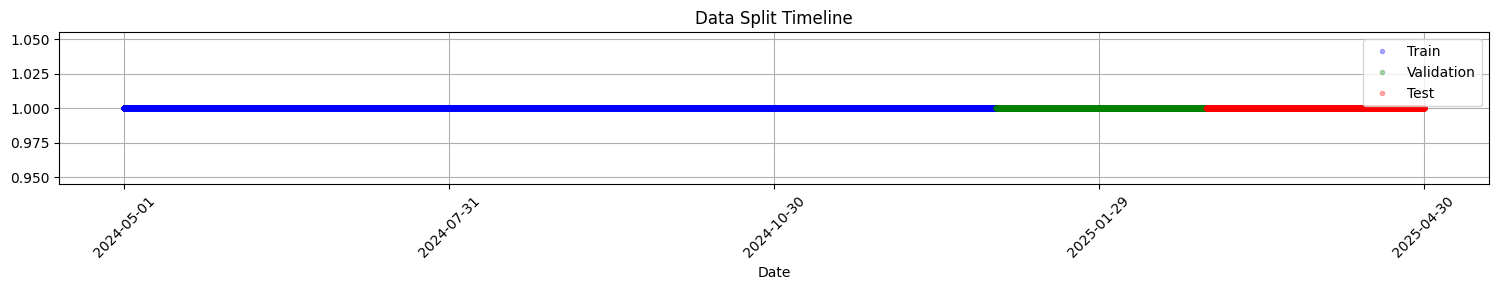

In [18]:
def annualize_factor(sampling: str):
    return ANNUALIZATION.get(sampling, 365*24)

def compute_metrics(equity_curve: pd.Series, sampling: str, turnover_series: pd.Series = None):
    ret = equity_curve.pct_change().dropna()
    ann = annualize_factor(sampling)
    mu = ret.mean() * ann
    sigma = ret.std() * math.sqrt(ann)
    sharpe = mu / (sigma + 1e-12)
    downside = ret[ret < 0].std() * math.sqrt(ann)
    sortino = mu / (downside + 1e-12)
    if len(equity_curve) > 1:
        # Calculate years based on number of samples and sampling frequency
        if isinstance(equity_curve.index, pd.DatetimeIndex):
            dt_years = (equity_curve.index[-1] - equity_curve.index[0]).total_seconds() / (365 * 24 * 3600)
        else:
            # If using RangeIndex, calculate based on sampling frequency
            samples = len(equity_curve)
            samples_per_year = annualize_factor(sampling)
            dt_years = samples / samples_per_year
        dt_years = float(dt_years) if float(dt_years) != 0 else 1e-12
        cagr = (equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (1/dt_years) - 1
    else:
        cagr = 0.0
    cummax = equity_curve.cummax()
    dd = (equity_curve / cummax - 1).min()
    maxdd = float(dd)
    calmar = mu / (abs(maxdd) + 1e-12)
    hit_ratio = (ret > 0).mean()
    turnover = turnover_series.mean() if turnover_series is not None and len(turnover_series)>0 else np.nan
    return {"CAGR": cagr, "Sharpe": sharpe, "Sortino": sortino, "MaxDrawdown": maxdd, "Calmar": calmar, "Volatility": sigma, "Turnover": turnover, "HitRatio": hit_ratio}

def plot_series(series: pd.Series, title: str):
    plt.figure(figsize=(10,4))
    plt.plot(series.index, series.values)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

def plot_splits(time_index: pd.DatetimeIndex, train_mask: np.ndarray, val_mask: np.ndarray, test_mask: np.ndarray = None):
    """Plot timeline showing training, validation, and test periods."""
    plt.figure(figsize=(15,3))
    
    # Convert time index to numeric for plotting
    x = np.arange(len(time_index))
    
    # Plot splits
    plt.plot(x[train_mask], [1]*train_mask.sum(), 'b.', label='Train', alpha=0.3)
    plt.plot(x[val_mask], [1]*val_mask.sum(), 'g.', label='Validation', alpha=0.3)
    if test_mask is not None:
        plt.plot(x[test_mask], [1]*test_mask.sum(), 'r.', label='Test', alpha=0.3)
    
    # Set x-axis ticks to show dates
    tick_locations = np.linspace(0, len(time_index)-1, 5, dtype=int)
    plt.xticks(tick_locations, time_index[tick_locations].strftime('%Y-%m-%d'), rotation=45)
    
    plt.title("Data Split Timeline")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def backtest_env(env: gym.Env, model=None, include_leverage: bool = False, include_returns: bool = False):
    # Get the unwrapped environment
    unwrapped = env.unwrapped if hasattr(env, 'unwrapped') else env
    
    obs, _ = env.reset()
    pv, turns, levs, actions, rets = [], [], [], [], []  # Initialize lists for portfolio value, turnover, leverage, actions, and returns
    
    for _ in range(len(unwrapped.R)-1):
        if model is None:
            action = np.array([0.0])  # Default to cash position (action=0)
        else:
            action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _, info = env.step(action)
        pv.append(info["portfolio_value"])
        turns.append(info["turnover"])
        levs.append(info["total_leverage"])  # Track leverage from info dict
        actions.append(info.get("action_taken", action[0] if isinstance(action, np.ndarray) else action))  # Track action taken
        rets.append(info.get("portfolio_log_ret", 0.0))  # Track log returns from info dict
        if done:
            break
            
    idx = pd.RangeIndex(start=0, stop=len(pv), step=1)
    ec = pd.Series(pv, index=idx)
    to = pd.Series(turns, index=idx)
    lev = pd.Series(levs, index=idx)  # Create leverage Series
    act = pd.Series(actions, index=idx)  # Create actions Series
    ret = pd.Series(rets, index=idx)  # Create returns Series
    
    if include_returns:
        return ec, to, lev, act, ret
    if include_leverage:
        return ec, to, lev, act
    return ec, to

print("Visualizing data splits timeline...")
plot_splits(TIME_INDEX, train_mask, val_mask, test_mask)

In [19]:
# Check the actual variables
print(f"all_X length: {len(all_X)}")
print(f"all_R length: {len(all_R)}")
print(f"all_VOL length: {len(all_VOL)}")
print(f"all_pairs length: {len(all_pairs)}")
print(f"all_sample_timestamps length: {len(all_sample_timestamps)}")
print(f"\ntimestamps variable (from last iteration): type={type(timestamps)}, length={len(timestamps)}")
if len(timestamps) > 0:
    print(f"First 5 timestamps: {timestamps[:5]}")

all_X length: 1774
all_R length: 1774
all_VOL length: 1774
all_pairs length: 2513758
all_sample_timestamps length: 2513758

timestamps variable (from last iteration): type=<class 'list'>, length=1417
First 5 timestamps: [Timestamp('2025-04-13 00:24:00+0000', tz='UTC'), Timestamp('2025-04-13 00:25:00+0000', tz='UTC'), Timestamp('2025-04-13 00:26:00+0000', tz='UTC'), Timestamp('2025-04-13 00:27:00+0000', tz='UTC'), Timestamp('2025-04-13 00:28:00+0000', tz='UTC')]


Slicing: 1687642 samples out of 2513758 fall in range 2024-05-01 00:00:00+00:00 to 2024-12-31 23:59:00+00:00
Slicing: 409513 samples out of 2513758 fall in range 2025-01-01 00:00:00+00:00 to 2025-02-28 23:59:00+00:00
Slicing: 409513 samples out of 2513758 fall in range 2025-01-01 00:00:00+00:00 to 2025-02-28 23:59:00+00:00
Using cpu device
Using cpu device
Logging to ./tb_logs/PPO_44
Logging to ./tb_logs/PPO_44
-----------------------------
| time/              |      |
|    fps             | 7184 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------
| time/              |      |
|    fps             | 7184 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 8192 |
-----------------------------
Eval num_timesteps=10000, episode_reward=-0.97 +/- 0.00
Episode length: 409512.00 +/- 0.00
-----------------------------------------
| eval/                   |     

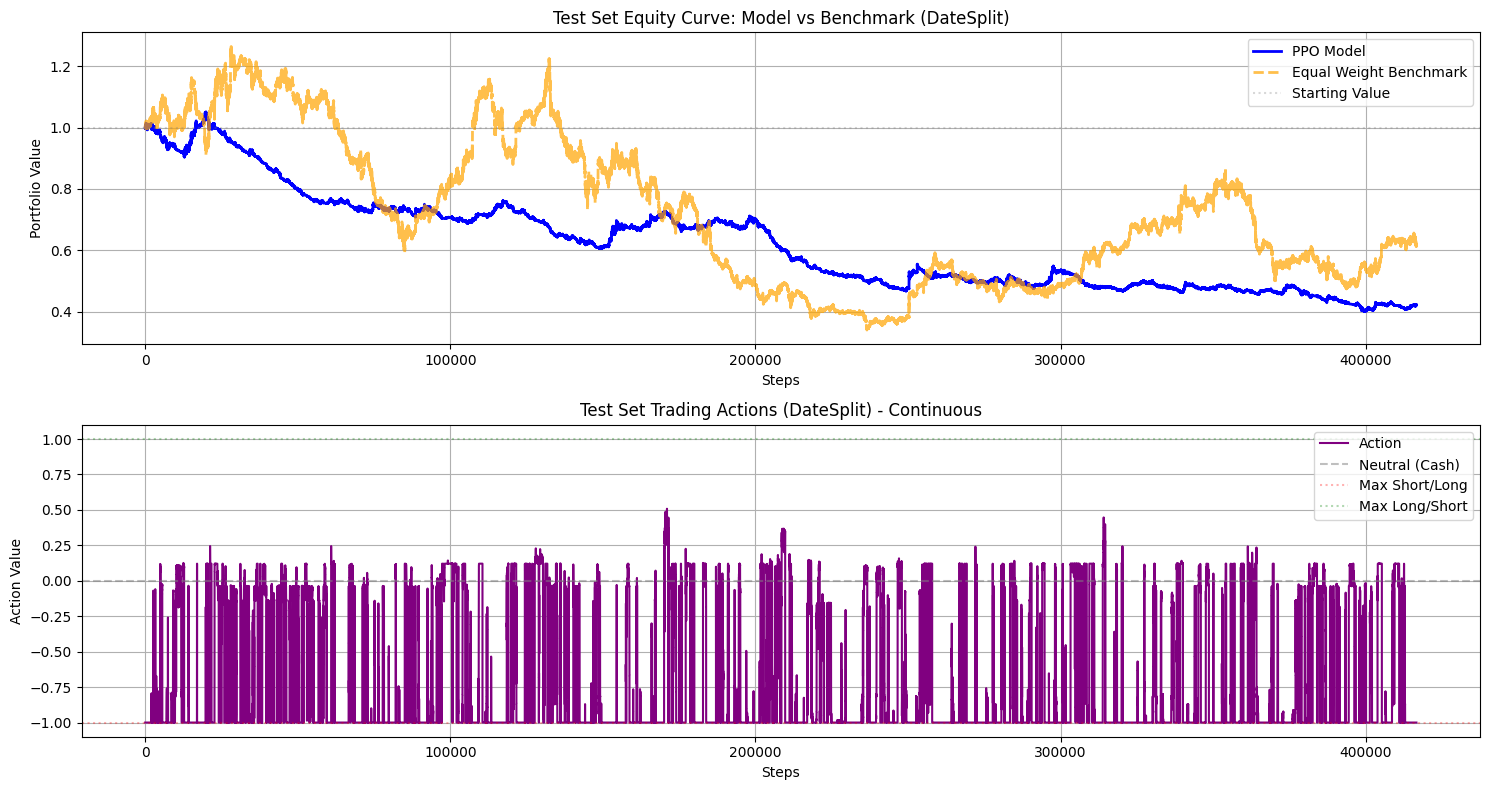

In [20]:
ensure_dir(CONFIG["IO"]["models_dir"])
ensure_dir(CONFIG["EVAL"]["reports_dir"])

# Check if required tensors exist
if 'X_all' not in globals() or 'R_all' not in globals() or 'VOL_all' not in globals() or 'SAMPLE_TIMESTAMPS' not in globals():
    raise NameError(
        "Required tensors (X_all, R_all, VOL_all, SAMPLE_TIMESTAMPS) not found!\n"
        "Please run the tensor construction cell (cell 29) before running this cell.\n"
        "The cell starts with: def build_state_tensor_for_interval..."
    )

RESULTS = []

for split in SPLITS:
    train_env = make_env_from_mask(split["train"], name=f"{split['name']}_train")
    val_env = make_env_from_mask(split["val"], name=f"{split['name']}_val")

    vec_train = DummyVecEnv([lambda env=train_env: env])
    vec_val = DummyVecEnv([lambda env=val_env: env])

    # PPO without custom LR schedule / entropy decay
    model = PPO(
        policy=CONFIG["RL"]["policy"],
        env=vec_train,
        gamma=CONFIG["RL"]["gamma"],
        gae_lambda=CONFIG["RL"]["gae_lambda"],
        clip_range=CONFIG["RL"]["clip_range"],
        n_steps=CONFIG["RL"]["n_steps"],
        batch_size=CONFIG["RL"]["batch_size"],
        learning_rate=CONFIG["RL"]["learning_rate"],  # fixed
        ent_coef=CONFIG["RL"]["ent_coef"],            # fixed
        vf_coef=CONFIG["RL"]["vf_coef"],
        max_grad_norm=CONFIG["RL"]["max_grad_norm"],
        tensorboard_log=CONFIG["IO"]["tb_logdir"],
        device="cpu",
        verbose=1
    )

    eval_callback = EvalCallback(
        vec_val,
        best_model_save_path=CONFIG["IO"]["models_dir"],
        log_path=CONFIG["IO"]["models_dir"],
        eval_freq=CONFIG["EVAL"]["frequency"],
        deterministic=True,
        render=False
    )

    model.learn(total_timesteps=CONFIG["RL"]["timesteps"], callback=eval_callback)

    # Save the final trained model
    model_path = os.path.join(CONFIG["IO"]["models_dir"], "final_model.zip")
    model.save(model_path)

    # Run on test set (unseen data)
    test_env = make_env_from_mask(split["test"], name=f"{split['name']}_test")
    ec, to, lev, act = backtest_env(test_env, model=model, include_leverage=True)

    # Compare against equal weight strategy on test set
    base_env = test_env.unwrapped if hasattr(test_env, "unwrapped") else test_env
    raw_returns = np.asarray(base_env.R)
    if raw_returns.ndim == 1:
        raw_returns = raw_returns.reshape(-1, 1)

    steps = min(len(ec.index) - 1, raw_returns.shape[0])
    if raw_returns.shape[1] == 0 or steps <= 0:
        ec_bench = pd.Series(np.ones(len(ec.index)), index=ec.index)
    else:
        ew = np.ones(raw_returns.shape[1]) / raw_returns.shape[1]
        ec_bench = [1.0]
        for i in range(steps):
            step_ret = float(np.dot(ew, raw_returns[i].reshape(-1)))
            ec_bench.append(ec_bench[-1] * math.exp(step_ret))
        if len(ec_bench) < len(ec.index):
            ec_bench.extend([ec_bench[-1]] * (len(ec.index) - len(ec_bench)))
        ec_bench = pd.Series(ec_bench[:len(ec.index)], index=ec.index)

    # Calculate metrics
    m_model = compute_metrics(ec, CONFIG["DATA"]["sampling"], to)
    m_ew = compute_metrics(ec_bench, CONFIG["DATA"]["sampling"])

    # Add average leverage to model metrics
    m_model["Avg_Leverage"] = lev.mean()
    m_model["Max_Leverage"] = lev.max()

    RESULTS.append({
        "split": split["name"],
        "model": m_model,
        "equal_weight": m_ew
    })

    if CONFIG["EVAL"]["plots"]:
        plt.figure(figsize=(15, 8))

        # Plot equity curves - Model vs Equal Weight Benchmark
        plt.subplot(2, 1, 1)
        plt.plot(ec.index, ec.values, label='PPO Model', color='blue', linewidth=2)
        plt.plot(ec_bench.index, ec_bench.values, label='Equal Weight Benchmark', color='orange', linewidth=2, linestyle='--', alpha=0.7)
        plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.3, label='Starting Value')
        plt.title(f"Test Set Equity Curve: Model vs Benchmark ({split['name']})")
        plt.xlabel("Steps")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.grid(True)

        # Plot actions
        plt.subplot(2, 1, 2)
        plt.plot(act.index, act.values, label='Action', drawstyle='steps-post', color='purple')
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral (Cash)')
        plt.axhline(y=-1, color='red', linestyle=':', alpha=0.3, label='Max Short/Long')
        plt.axhline(y=1, color='green', linestyle=':', alpha=0.3, label='Max Long/Short')
        plt.ylim(-1.1, 1.1)
        plt.title(f"Test Set Trading Actions ({split['name']}) - Continuous")
        plt.xlabel("Steps")
        plt.ylabel("Action Value")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()


In [21]:
# Create a DataFrame with all results
rows = []
for res in RESULTS:
    row = {"split": res["split"]}
    for k, metrics in res.items():
        if k == "split":
            continue
        for mname, mval in metrics.items():
            row[f"{k}_{mname}"] = mval
    rows.append(row)

df_results = pd.DataFrame(rows)

# Reorder columns to group related metrics together
column_order = ['split']
for model_type in ['model', 'equal_weight']:
    for metric in ['CAGR', 'Sharpe', 'Sortino', 'Calmar', 'MaxDrawdown', 'Volatility', 'Turnover', 'HitRatio']:
        col = f"{model_type}_{metric}"
        if col in df_results.columns:
            column_order.append(col)
    # Add leverage metrics for model only
    if model_type == 'model':
        for metric in ['Avg_Leverage', 'Max_Leverage']:
            col = f"{model_type}_{metric}"
            if col in df_results.columns:
                column_order.append(col)

df_results = df_results[column_order]

# Format only numeric columns, leave 'split' column as-is
format_dict = {col: "{:.4f}" for col in df_results.columns if col != 'split'}
display(df_results.style.format(format_dict))

,split,model_CAGR,model_Sharpe,model_Sortino,model_Calmar,model_MaxDrawdown,model_Volatility,model_Turnover,model_HitRatio,model_Avg_Leverage,model_Max_Leverage,equal_weight_CAGR,equal_weight_Sharpe,equal_weight_Sortino,equal_weight_Calmar,equal_weight_MaxDrawdown,equal_weight_Volatility,equal_weight_Turnover,equal_weight_HitRatio
0,DateSplit,-0.6632,-3.3404,-4.2925,-1.6781,-0.6197,0.3113,0.0030,0.4833,0.7486,1.0000,-0.4518,-0.2155,-0.3027,-0.2658,-0.7314,0.9021,nan,0.4988


In [22]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
ensure_dir(CONFIG["EVAL"]["reports_dir"])
out_json = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.json")
out_csv  = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.csv")
df_results.to_csv(out_csv, index=False)
with open(out_json, "w") as f:
    json.dump(RESULTS, f, indent=2)
print("Saved:", out_json, "and", out_csv)

Saved: ./reports/metrics_20251119_162616.json and ./reports/metrics_20251119_162616.csv


Loading model from: ./models/best_model.zip
Slicing: 416603 samples out of 2513758 fall in range 2025-03-01 00:00:00+00:00 to 2025-04-30 23:59:00+00:00

Running backtest on test set...

Running backtest on test set...

Backtest completed!
Test period: 2025-03-01 00:00:00 to 2025-04-30 23:59:59
Total steps: 416602
Model final value: 1.9788 (97.88%)
Benchmark final value: 0.6209 (-37.91%)
Average leverage: 1.0000
Average turnover: 0.0000

Backtest completed!
Test period: 2025-03-01 00:00:00 to 2025-04-30 23:59:59
Total steps: 416602
Model final value: 1.9788 (97.88%)
Benchmark final value: 0.6209 (-37.91%)
Average leverage: 1.0000
Average turnover: 0.0000


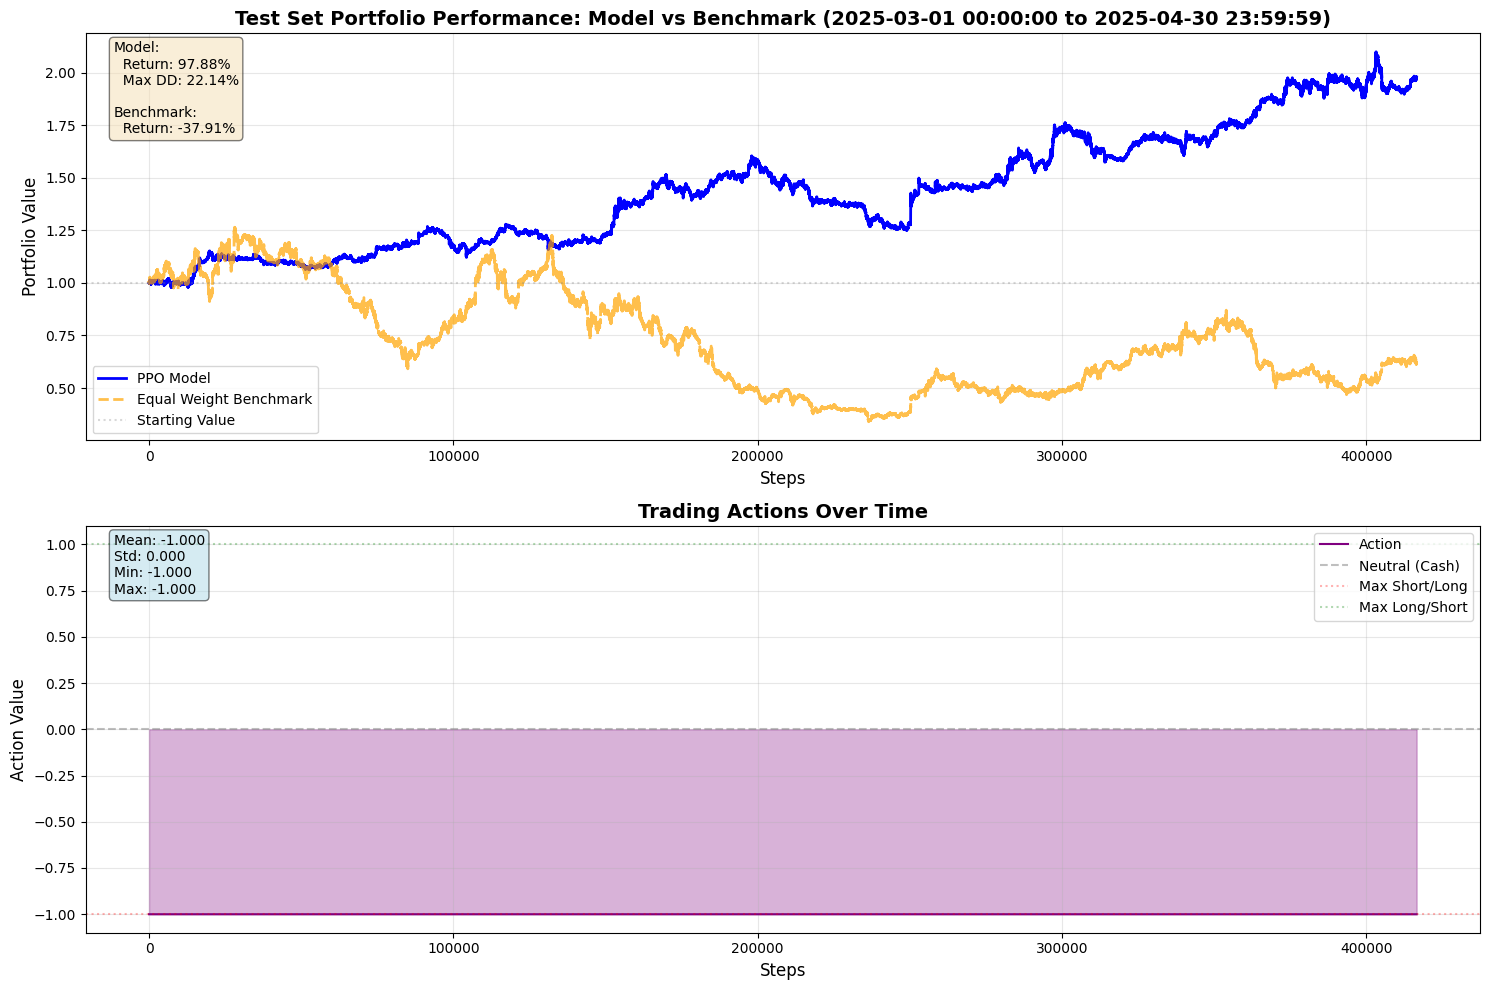


DETAILED BACKTEST STATISTICS

Portfolio Metrics:
  Starting Value:        1.0000
  Ending Value:          1.9788
  Total Return:          97.88%
  Max Drawdown:          22.14%
  Volatility (Returns):  0.000505

Trading Statistics:
  Average Action:        -1.0000
  Action Std Dev:        0.0000
  Action Range:          [-1.0000, -1.0000]
  Avg Turnover:          0.0000
  Avg Leverage:          1.0000
  Max Leverage:          1.0000

Action Distribution:
  Neutral (|action| < 0.1): 0.00%
  Long (action > 0.1):      0.00%
  Short (action < -0.1):    100.00%


In [23]:
# Load the best trained model
best_split = SPLITS[0]
model_path = os.path.join(CONFIG["IO"]["models_dir"], "best_model.zip")

# Check if best model exists, otherwise use the split model
if not os.path.exists(model_path):
    #model_path = os.path.join(CONFIG["IO"]["models_dir"], f"ppo_{best_split['name']}.zip")
    model_path = os.path.join(CONFIG["IO"]["models_dir"], "final_model.zip")

print(f"Loading model from: {model_path}")
model = PPO.load(model_path)

# Create test environment
test_env = make_env_from_mask(best_split["test"], name="test_backtest")

# Run backtest
print("\nRunning backtest on test set...")
ec, to, lev, act = backtest_env(test_env, model=model, include_leverage=True)

# Calculate equal weight benchmark for comparison
base_env = test_env.unwrapped if hasattr(test_env, "unwrapped") else test_env
raw_returns = np.asarray(base_env.R)
if raw_returns.ndim == 1:
    raw_returns = raw_returns.reshape(-1, 1)

steps = min(len(ec.index) - 1, raw_returns.shape[0])
if raw_returns.shape[1] == 0 or steps <= 0:
    ec_bench = pd.Series(np.ones(len(ec.index)), index=ec.index)
else:
    ew = np.ones(raw_returns.shape[1]) / raw_returns.shape[1]
    ec_bench = [1.0]
    for i in range(steps):
        step_ret = float(np.dot(ew, raw_returns[i].reshape(-1)))
        ec_bench.append(ec_bench[-1] * math.exp(step_ret))
    if len(ec_bench) < len(ec.index):
        ec_bench.extend([ec_bench[-1]] * (len(ec.index) - len(ec_bench)))
    ec_bench = pd.Series(ec_bench[:len(ec.index)], index=ec.index)

# Get test period dates
test_period_start = CONFIG["SPLITS"]["test"][0]
test_period_end = CONFIG["SPLITS"]["test"][1]

print("\nBacktest completed!")
print(f"Test period: {test_period_start} to {test_period_end}")
print(f"Total steps: {len(ec)}")
print(f"Model final value: {ec.iloc[-1]:.4f} ({(ec.iloc[-1] - 1) * 100:.2f}%)")
print(f"Benchmark final value: {ec_bench.iloc[-1]:.4f} ({(ec_bench.iloc[-1] - 1) * 100:.2f}%)")
print(f"Average leverage: {lev.mean():.4f}")
print(f"Average turnover: {to.mean():.4f}")

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Portfolio Value - Model vs Benchmark
axes[0].plot(ec.index, ec.values, label='PPO Model', color='blue', linewidth=2)
axes[0].plot(ec_bench.index, ec_bench.values, label='Equal Weight Benchmark', color='orange', linewidth=2, linestyle='--', alpha=0.7)
axes[0].axhline(y=1.0, color='gray', linestyle=':', alpha=0.3, label='Starting Value')
axes[0].set_title(f'Test Set Portfolio Performance: Model vs Benchmark ({test_period_start} to {test_period_end})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Steps', fontsize=12)
axes[0].set_ylabel('Portfolio Value', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Add performance metrics as text
final_value = ec.iloc[-1]
total_return = (final_value - 1) * 100
max_drawdown = (ec / ec.cummax() - 1).min()
bench_return = (ec_bench.iloc[-1] - 1) * 100
metrics_text = f'Model:\n  Return: {total_return:.2f}%\n  Max DD: {abs(max_drawdown) * 100:.2f}%\n\nBenchmark:\n  Return: {bench_return:.2f}%'
axes[0].text(0.02, 0.98, metrics_text, transform=axes[0].transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Trading Actions
axes[1].plot(act.index, act.values, label='Action', drawstyle='steps-post', color='purple', linewidth=1.5)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral (Cash)')
axes[1].axhline(y=-1, color='red', linestyle=':', alpha=0.3, label='Max Short/Long')
axes[1].axhline(y=1, color='green', linestyle=':', alpha=0.3, label='Max Long/Short')
axes[1].fill_between(act.index, act.values, 0, alpha=0.3, color='purple')
axes[1].set_ylim(-1.1, 1.1)
axes[1].set_title('Trading Actions Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Steps', fontsize=12)
axes[1].set_ylabel('Action Value', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Add action statistics as text
action_stats = f'Mean: {act.mean():.3f}\nStd: {act.std():.3f}\nMin: {act.min():.3f}\nMax: {act.max():.3f}'
axes[1].text(0.02, 0.98, action_stats, transform=axes[1].transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()
plt.close(fig)

# Print detailed statistics
print("\n" + "="*60)
print("DETAILED BACKTEST STATISTICS")
print("="*60)
print("\nPortfolio Metrics:")
print("  Starting Value:        1.0000")
print(f"  Ending Value:          {ec.iloc[-1]:.4f}")
print(f"  Total Return:          {(ec.iloc[-1] - 1) * 100:.2f}%")
print(f"  Max Drawdown:          {abs(max_drawdown) * 100:.2f}%")
print(f"  Volatility (Returns):  {ec.pct_change().std():.6f}")

print("\nTrading Statistics:")
print(f"  Average Action:        {act.mean():.4f}")
print(f"  Action Std Dev:        {act.std():.4f}")
print(f"  Action Range:          [{act.min():.4f}, {act.max():.4f}]")
print(f"  Avg Turnover:          {to.mean():.4f}")
print(f"  Avg Leverage:          {lev.mean():.4f}")
print(f"  Max Leverage:          {lev.max():.4f}")

# Action distribution
neutral_pct = ((act.abs() < 0.1).sum() / len(act)) * 100
long_pct = ((act > 0.1).sum() / len(act)) * 100
short_pct = ((act < -0.1).sum() / len(act)) * 100

print("\nAction Distribution:")
print(f"  Neutral (|action| < 0.1): {neutral_pct:.2f}%")
print(f"  Long (action > 0.1):      {long_pct:.2f}%")
print(f"  Short (action < -0.1):    {short_pct:.2f}%")
print("="*60)


Generating returns visualization...
Slicing: 416603 samples out of 2513758 fall in range 2025-03-01 00:00:00+00:00 to 2025-04-30 23:59:00+00:00


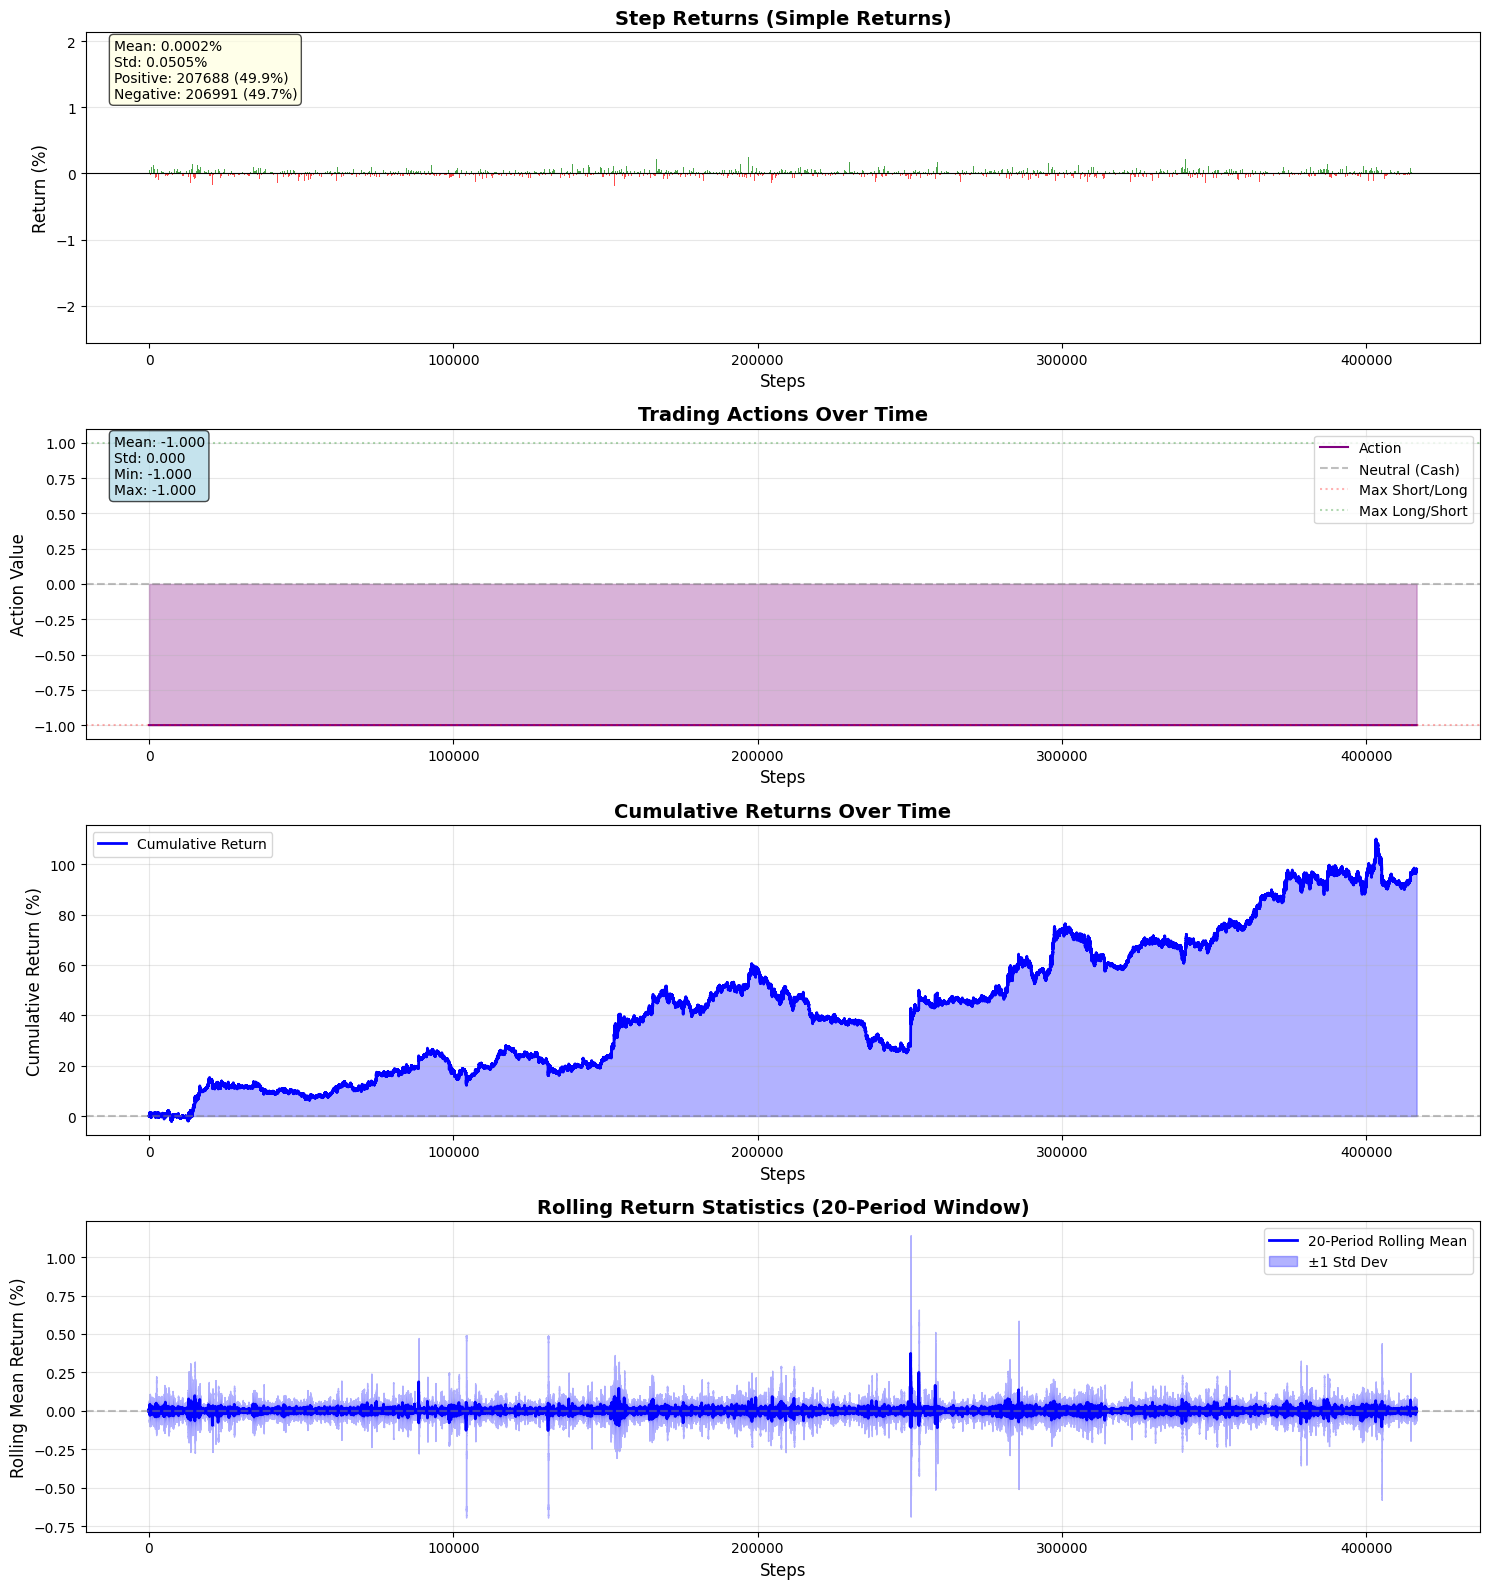


RETURN STATISTICS

Step Returns (Simple Returns):
  Mean:              0.0002%
  Median:            0.0000%
  Std Dev:           0.0505%
  Min:               -2.3484%
  Max:               1.9183%
  Skewness:          -0.0027
  Kurtosis:          55.9995

Return Distribution:
  Positive steps:    207688 (49.9%)
  Negative steps:    206991 (49.7%)
  Zero steps:        1923 (0.5%)

Cumulative:
  Total Return:      98.07%
  Arithmetic Mean:   0.0002% per step
  Geometric Mean:    0.0002% per step


In [24]:
# Create a plot showing returns on each timestep
print("\nGenerating returns visualization...")

# Get returns from test environment backtest
test_env_returns = make_env_from_mask(best_split["test"], name="test_returns")
ec_ret, to_ret, lev_ret, act_ret, log_ret = backtest_env(test_env_returns, model=model, include_returns=True)

# Convert log returns to simple returns (stable): use expm1 for precision
ret = np.expm1(log_ret)

# Create comprehensive returns visualization with actions
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

# Plot 1: Step Returns (Simple Returns as %)
ret_pct = ret * 100  # Convert to percentage
axes[0].bar(ret.index, ret_pct.values, color=['green' if r > 0 else 'red' for r in ret_pct.values], alpha=0.7, width=1.0)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_title('Step Returns (Simple Returns)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Steps', fontsize=12)
axes[0].set_ylabel('Return (%)', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# Add statistics
ret_mean = ret.mean() * 100
ret_std = ret.std() * 100
ret_pos = (ret > 0).sum()
ret_neg = (ret < 0).sum()
ret_stats = f'Mean: {ret_mean:.4f}%\nStd: {ret_std:.4f}%\nPositive: {ret_pos} ({ret_pos/len(ret)*100:.1f}%)\nNegative: {ret_neg} ({ret_neg/len(ret)*100:.1f}%)'
axes[0].text(0.02, 0.98, ret_stats, transform=axes[0].transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

# Plot 2: Trading Actions
axes[1].plot(act_ret.index, act_ret.values, label='Action', drawstyle='steps-post', color='purple', linewidth=1.5)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral (Cash)')
axes[1].axhline(y=-1, color='red', linestyle=':', alpha=0.3, label='Max Short/Long')
axes[1].axhline(y=1, color='green', linestyle=':', alpha=0.3, label='Max Long/Short')
axes[1].fill_between(act_ret.index, act_ret.values, 0, alpha=0.3, color='purple')
axes[1].set_ylim(-1.1, 1.1)
axes[1].set_title('Trading Actions Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Steps', fontsize=12)
axes[1].set_ylabel('Action Value', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Add action statistics
action_stats = f'Mean: {act_ret.mean():.3f}\nStd: {act_ret.std():.3f}\nMin: {act_ret.min():.3f}\nMax: {act_ret.max():.3f}'
axes[1].text(0.02, 0.98, action_stats, transform=axes[1].transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Plot 3: Cumulative Returns (%)
cumulative_ret = ((1 + ret).cumprod() - 1) * 100
axes[2].plot(cumulative_ret.index, cumulative_ret.values, color='blue', linewidth=2, label='Cumulative Return')
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[2].fill_between(cumulative_ret.index, cumulative_ret.values, 0, alpha=0.3, color='blue')
axes[2].set_title('Cumulative Returns Over Time', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Steps', fontsize=12)
axes[2].set_ylabel('Cumulative Return (%)', fontsize=12)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

# Plot 4: Rolling Statistics (20-period window)
window_raw = len(ret) // 4  # Base window from data length
window = max(1, min(20, window_raw))  # Ensure valid window size
rolling_mean = (ret * 100).rolling(window=window).mean()
rolling_std = (ret * 100).rolling(window=window).std()

axes[3].plot(rolling_mean.index, rolling_mean.values, color='blue', linewidth=2, label=f'{window}-Period Rolling Mean')
axes[3].fill_between(rolling_mean.index, 
                      rolling_mean - rolling_std, 
                      rolling_mean + rolling_std, 
                      alpha=0.3, color='blue', label='±1 Std Dev')
axes[3].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[3].set_title(f'Rolling Return Statistics ({window}-Period Window)', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Steps', fontsize=12)
axes[3].set_ylabel('Rolling Mean Return (%)', fontsize=12)
axes[3].legend(fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close(fig)

# Print return statistics
print("\n" + "="*60)
print("RETURN STATISTICS")
print("="*60)
print("\nStep Returns (Simple Returns):")
print(f"  Mean:              {ret.mean() * 100:.4f}%")
print(f"  Median:            {ret.median() * 100:.4f}%")
print(f"  Std Dev:           {ret.std() * 100:.4f}%")
print(f"  Min:               {ret.min() * 100:.4f}%")
print(f"  Max:               {ret.max() * 100:.4f}%")
print(f"  Skewness:          {ret.skew():.4f}")
print(f"  Kurtosis:          {ret.kurtosis():.4f}")
print("\nReturn Distribution:")
print(f"  Positive steps:    {(ret > 0).sum()} ({(ret > 0).sum()/len(ret)*100:.1f}%)")
print(f"  Negative steps:    {(ret < 0).sum()} ({(ret < 0).sum()/len(ret)*100:.1f}%)")
print(f"  Zero steps:        {(ret == 0).sum()} ({(ret == 0).sum()/len(ret)*100:.1f}%)")
print("\nCumulative:")
print(f"  Total Return:      {((1 + ret).prod() - 1) * 100:.2f}%")
print(f"  Arithmetic Mean:   {ret.mean() * 100:.4f}% per step")
print(f"  Geometric Mean:    {(((1 + ret).prod()) ** (1/len(ret)) - 1) * 100:.4f}% per step")
print("="*60)

# Clean up
test_env_returns.close()

## Inference: Generate Trading Signals

This cell contains a standalone inference function that can be copied to a separate Python script.
The function takes a single observation (features for one timestep) and outputs a trading signal in JSON format.

In [25]:
"""
STANDALONE INFERENCE FUNCTION
==============================
This function can be copied to a separate Python script for production use.
It takes features for a single timestep and generates a trading signal.

Required imports for standalone use:
    import numpy as np
    import pandas as pd
    from datetime import datetime
    from stable_baselines3 import PPO

Feature structure:
------------------
Single asset features (per asset): 12 features
    ['close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow', 
     'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow', 
     'funding', 'fundingMinutesLeft']

Pair features (for both assets combined): 8 features
    ['alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman', 
     'spreadNormMa', 'spreadNormVol']
"""

def continuous_action_to_weights(action: float) -> tuple[float, float]:
    """
    Convert continuous action [-1, 1] to portfolio weights.
    
    Parameters
    ----------
    action : float
        Action value from -1 (short asset1/long asset2) to 1 (long asset1/short asset2)
    
    Returns
    -------
    tuple[float, float]
        (asset1_weight, asset2_weight)
    """
    action = np.clip(action, -1.0, 1.0)
    position_size = action * 0.5
    asset1_weight = position_size
    asset2_weight = -position_size
    return asset1_weight, asset2_weight


def generate_signal_from_features(
    model_path: str,
    asset1: str,
    asset2: str,
    asset1_features: dict,
    asset2_features: dict,
    pair_features: dict,
    current_portfolio_weights: tuple[float, float, float] = (0.0, 0.0, 1.0),
    lookback_window: int = 24,
    timestamp: str = None,
    notional_usd: float = 100,
    bar_timeframe: str = "1h",
    exchange: str = "binance_perpetual",
    fresh_for_seconds: int = 3600,
    version: int = 1
) -> dict:
    """
    Generate a trading signal from features for a single timestep.
    
    This is a STANDALONE function that can be copied to a separate Python script.
    
    Parameters
    ----------
    model_path : str
        Path to the trained PPO model (.zip file)
    asset1 : str
        First asset symbol (e.g., "ETH")
    asset2 : str
        Second asset symbol (e.g., "BTC")
    asset1_features : dict
        Features for asset1 with keys:
        ['close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow',
         'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow',
         'funding', 'fundingMinutesLeft']
        Each value should be a list/array of length lookback_window
    asset2_features : dict
        Features for asset2 (same structure as asset1_features)
    pair_features : dict
        Combined pair features with keys:
        ['alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman',
         'spreadNormMa', 'spreadNormVol']
        Each value should be a list/array of length lookback_window
    current_portfolio_weights : tuple[float, float, float]
        Current portfolio weights (asset1_weight, asset2_weight, cash_weight)
        Default: (0.0, 0.0, 1.0) = 100% cash position
    lookback_window : int
        Number of historical timesteps (default: 24)
    timestamp : str, optional
        ISO format timestamp. If None, uses current time.
    notional_usd : float
        Notional value in USD
    bar_timeframe : str
        Timeframe of bars (e.g., "1h", "1m")
    exchange : str
        Exchange identifier
    fresh_for_seconds : int
        Signal validity duration in seconds
    version : int
        Signal format version
    
    Returns
    -------
    dict
        Trading signal in JSON format
    
    Example
    -------
    >>> signal = generate_signal_from_features(
    ...     model_path="./models/ppo_model.zip",
    ...     asset1="ETH",
    ...     asset2="BTC",
    ...     asset1_features={
    ...         'close': [0.1, 0.2, ...],  # 24 values
    ...         'closeBias': [0.05, -0.03, ...],
    ...         # ... other 10 features
    ...     },
    ...     asset2_features={
    ...         'close': [0.15, 0.18, ...],
    ...         # ... other 11 features
    ...     },
    ...     pair_features={
    ...         'alpha': [0.01, 0.02, ...],  # 24 values
    ...         'beta': [0.98, 0.99, ...],
    ...         # ... other 6 features
    ...     },
    ...     current_portfolio_weights=(0.3, -0.3, 0.4)  # Current position
    ... )
    """
    
    # Define feature order (must match training order)
    SINGLE_ASSET_FEATURES = [
        'close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow',
        'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow',
        'funding', 'fundingMinutesLeft'
    ]
    
    PAIR_FEATURES = [
        'alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman',
        'spreadNormMa', 'spreadNormVol'
    ]
    
    # Validate inputs
    for feat in SINGLE_ASSET_FEATURES:
        if feat not in asset1_features:
            raise ValueError(f"Missing feature '{feat}' in asset1_features")
        if feat not in asset2_features:
            raise ValueError(f"Missing feature '{feat}' in asset2_features")
        if len(asset1_features[feat]) != lookback_window:
            raise ValueError(f"asset1_features['{feat}'] must have length {lookback_window}")
        if len(asset2_features[feat]) != lookback_window:
            raise ValueError(f"asset2_features['{feat}'] must have length {lookback_window}")
    
    # Validate pair features
    for feat in PAIR_FEATURES:
        if feat not in pair_features:
            raise ValueError(f"Missing feature '{feat}' in pair_features")
        if len(pair_features[feat]) != lookback_window:
            raise ValueError(f"pair_features['{feat}'] must have length {lookback_window}")
    
    # Validate portfolio weights
    if len(current_portfolio_weights) != 3:
        raise ValueError(f"current_portfolio_weights must have length 3, got {len(current_portfolio_weights)}")
    
    # Build observation tensor
    # Shape: (n_features * lookback_window + 3,)
    # - Market features: (8 pair + 12 asset1 + 12 asset2) * lookback_window = 32 * 24 = 768 dimensions
    # - Position features: 3 portfolio weights (asset1, asset2, cash) = 3 dimensions
    # Total observation shape: (771,) with default lookback=24
    
    n_pair_features = len(PAIR_FEATURES)
    n_asset_features = len(SINGLE_ASSET_FEATURES)
    n_total_features = n_pair_features + 2 * n_asset_features  # pair + asset1 + asset2
    
    market_obs = np.zeros((n_total_features, lookback_window), dtype=np.float32)
    
    # Fill features in order: pair features, then asset1 features, then asset2 features
    idx = 0
    
    # 1. Fill pair features
    for feat in PAIR_FEATURES:
        market_obs[idx, :] = pair_features[feat]
        idx += 1
    
    # 2. Fill asset1 features
    for feat in SINGLE_ASSET_FEATURES:
        market_obs[idx, :] = asset1_features[feat]
        idx += 1
    
    # 3. Fill asset2 features
    for feat in SINGLE_ASSET_FEATURES:
        market_obs[idx, :] = asset2_features[feat]
        idx += 1
    
    # Flatten market features to (n_features * lookback_window,)
    market_obs = market_obs.reshape(-1).astype(np.float32)
    
    # Add portfolio weights to observation
    position_obs = np.array(current_portfolio_weights, dtype=np.float32)
    
    # Concatenate market features and position features
    obs = np.concatenate([market_obs, position_obs])
    
    # Clip observation values (same as training)
    obs = np.clip(obs, -5.0, 5.0)
    
    # Load model and predict
    model = PPO.load(model_path)
    action, _ = model.predict(obs, deterministic=True)
    
    # Convert action to weights
    action_value = float(action[0]) if isinstance(action, np.ndarray) else float(action)
    asset1_weight, asset2_weight = continuous_action_to_weights(action_value)
    
    # Get or generate timestamp
    if timestamp is None:
        timestamp = pd.Timestamp.now(tz='UTC').strftime("%Y-%m-%dT%H:%M:%SZ")
    elif isinstance(timestamp, pd.Timestamp):
        timestamp = timestamp.strftime("%Y-%m-%dT%H:%M:%SZ")
    
    # Create signal JSON
    signal = {
        "timestamp": timestamp,
        "bar_timeframe": bar_timeframe,
        "pair": {
            "asset1": asset1,
            "asset2": asset2
        },
        "markets": {
            "exchange": exchange,
            "asset1": f"{asset1}-USDT",
            "asset2": f"{asset2}-USDT"
        },
        "weights": {
            "asset1": float(asset1_weight),
            "asset2": float(asset2_weight)
        },
        "notional_usd": notional_usd,
        "fresh_for_seconds": fresh_for_seconds,
        "version": version
    }
    
    return signal
print("  - Features for a single timestep:")
print("    * pair_features: 8 features x lookback_window values")
print("    * current_portfolio_weights: (asset1, asset2, cash) tuple")
print("  - Note: asset1_features and asset2_features parameters exist for")
print("    API compatibility but are not currently used by the model")
print("\nExample below demonstrates usage with TEST data (unseen data)...")
print("=" * 80)





print("=" * 80)
print("\nExample below demonstrates usage with TEST data (unseen data)...")
print("    * pair_features: 8 features x lookback_window values")
print("    * asset2_features: 12 features x lookback_window values")
print("    * asset1_features: 12 features x lookback_window values")
print("  - Features for a single timestep:")
print("    * asset1_features: 12 features x lookback_window values")
print("    * asset2_features: 12 features x lookback_window values")
print("    * pair_features: 8 features x lookback_window values")
print("\nExample below demonstrates usage with TEST data (unseen data)...")
print("=" * 80)

  - Features for a single timestep:
    * pair_features: 8 features x lookback_window values
    * current_portfolio_weights: (asset1, asset2, cash) tuple
  - Note: asset1_features and asset2_features parameters exist for
    API compatibility but are not currently used by the model

Example below demonstrates usage with TEST data (unseen data)...

Example below demonstrates usage with TEST data (unseen data)...
    * pair_features: 8 features x lookback_window values
    * asset2_features: 12 features x lookback_window values
    * asset1_features: 12 features x lookback_window values
  - Features for a single timestep:
    * asset1_features: 12 features x lookback_window values
    * asset2_features: 12 features x lookback_window values
    * pair_features: 8 features x lookback_window values

Example below demonstrates usage with TEST data (unseen data)...


In [26]:
# Demo: Test the standalone function with test data
print("\nRunning demo with test data...\n")

# Load the trained model
best_split = SPLITS[0]
#model_path = os.path.join(CONFIG["IO"]["models_dir"], f"ppo_{best_split['name']}.zip")
model_path = os.path.join(CONFIG["IO"]["models_dir"], "final_model.zip")

if os.path.exists(model_path):
    try:
        # Get a sample from test data
        test_env = make_env_from_mask(best_split["test"], name="test_inference")
        unwrapped_env = test_env.unwrapped if hasattr(test_env, 'unwrapped') else test_env
        
        # Get the first pair
        sample_pair = all_pairs[0]
        asset1, asset2 = sample_pair
    except Exception as e:
        print(f"✗ Error setting up test environment: {str(e)}")
        raise
    
    # Extract features from the first timestep in test set
    # Shape of X: (samples, 1, n_features, lookback)
    sample_idx = 0
    sample_features = unwrapped_env.X[sample_idx, 0, :, :]  # (n_features, lookback)
    
    # For demo, we'll construct the feature dictionaries
    # Note: In production, you'd receive these features from your data pipeline
    lookback = CONFIG["ENV"]["lookback_window"]
    
    # Define feature names (must match training order)
    PAIR_FEATURES = [
        'alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman',
        'spreadNormMa', 'spreadNormVol'
    ]
    
    SINGLE_ASSET_FEATURES = [
        'close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow',
        'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow',
        'funding', 'fundingMinutesLeft'
    ]
    
    # Extract features from sample in the correct order: pair, asset1, asset2
    n_pair_features = len(PAIR_FEATURES)
    n_asset_features = len(SINGLE_ASSET_FEATURES)
    
    # Build pair_features dict (first 8 features)
    pair_features = {}
    for i, feat_name in enumerate(PAIR_FEATURES):
        if i < sample_features.shape[0]:
            pair_features[feat_name] = sample_features[i, :].tolist()
    
    # Build asset1_features dict (next 12 features)
    asset1_features = {}
    for i, feat_name in enumerate(SINGLE_ASSET_FEATURES):
        feat_idx = n_pair_features + i
        if feat_idx < sample_features.shape[0]:
            asset1_features[feat_name] = sample_features[feat_idx, :].tolist()
        else:
            asset1_features[feat_name] = [0.0] * lookback
    
    # Build asset2_features dict (last 12 features)
    asset2_features = {}
    for i, feat_name in enumerate(SINGLE_ASSET_FEATURES):
        feat_idx = n_pair_features + n_asset_features + i
        if feat_idx < sample_features.shape[0]:
            asset2_features[feat_name] = sample_features[feat_idx, :].tolist()
        else:
            asset2_features[feat_name] = [0.0] * lookback
    
    # Get timestamp from test set
    test_timestamps = SAMPLE_TIMESTAMPS[SAMPLE_TIMESTAMPS >= pd.Timestamp(CONFIG["SPLITS"]["test"][0], tz='UTC')]
    if len(test_timestamps) > 0:
        sample_timestamp = test_timestamps[0]
    else:
        sample_timestamp = None
    
    # Generate signal using standalone function
    # Start with a neutral position (100% cash) for the first prediction
    current_weights = (0.0, 0.0, 1.0)  # (asset1, asset2, cash)
    
    try:
        signal = generate_signal_from_features(
            model_path=model_path,
            asset1=asset1,
            asset2=asset2,
            asset1_features=asset1_features,
            asset2_features=asset2_features,
            pair_features=pair_features,
            current_portfolio_weights=current_weights,
            lookback_window=lookback,
            timestamp=sample_timestamp,
            notional_usd=100,
            bar_timeframe="1h",
            exchange="binance_perpetual",
            fresh_for_seconds=3600,
            version=1
        )
        
        print("✓ Successfully generated signal using standalone function!")
        print("✓ Inference performed on TEST SET (unseen data)\n")
        print("Sample output:")
        print(json.dumps(signal, indent=2))
        
        # Save as example
        example_file = os.path.join(CONFIG["EVAL"]["reports_dir"], "signal_example_test.json")
        with open(example_file, "w") as f:
            json.dump(signal, f, indent=2)
        print(f"\n✓ Saved example signal to: {example_file}")
        print(f"✓ Test period: {CONFIG['SPLITS']['test'][0]} to {CONFIG['SPLITS']['test'][1]}")
        
    except Exception as e:
        print(f"✗ Error generating signal: {str(e)}")
        import traceback
        traceback.print_exc()
    finally:
        # Clean up test environment
        if 'test_env' in locals():
            test_env.close()
    
else:
    print(f"✗ Model not found at {model_path}")
    print("Please run the training cell first.")


Running demo with test data...

Slicing: 416603 samples out of 2513758 fall in range 2025-03-01 00:00:00+00:00 to 2025-04-30 23:59:00+00:00
✓ Successfully generated signal using standalone function!
✓ Inference performed on TEST SET (unseen data)

Sample output:
{
  "timestamp": "2025-03-15T00:24:00Z",
  "bar_timeframe": "1h",
  "pair": {
    "asset1": "AAVE",
    "asset2": "SUI"
  },
  "markets": {
    "exchange": "binance_perpetual",
    "asset1": "AAVE-USDT",
    "asset2": "SUI-USDT"
  },
  "weights": {
    "asset1": -0.5,
    "asset2": 0.5
  },
  "notional_usd": 100,
  "fresh_for_seconds": 3600,
  "version": 1
}

✓ Saved example signal to: ./reports/signal_example_test.json
✓ Test period: 2025-03-01 00:00:00 to 2025-04-30 23:59:59
✓ Successfully generated signal using standalone function!
✓ Inference performed on TEST SET (unseen data)

Sample output:
{
  "timestamp": "2025-03-15T00:24:00Z",
  "bar_timeframe": "1h",
  "pair": {
    "asset1": "AAVE",
    "asset2": "SUI"
  },
  "mar

In [27]:
# Diagnostics: verify action sign mapping vs realized returns
print("\nVerifying action sign mapping...")
try:
    # If available from earlier cell, reuse log_ret and act_ret; else recompute quickly
    if 'log_ret' in globals() and isinstance(log_ret, pd.Series) and 'act_ret' in globals():
        ret_diag = np.expm1(log_ret).astype(float)
        act_diag = act_ret.astype(float)
    else:
        _env_diag = make_env_from_mask(best_split["test"], name="diag_returns")
        _, _, _, act_diag, log_ret_diag = backtest_env(_env_diag, model=model, include_returns=True)
        ret_diag = np.expm1(log_ret_diag).astype(float)
        _env_diag.close()
    # Align indexes
    idx = ret_diag.index.intersection(act_diag.index)
    ret_diag = ret_diag.loc[idx]
    act_diag = act_diag.loc[idx]
    corr = act_diag.corr(ret_diag)
    print(f"Correlation(action, realized return): {corr:.4f}")
    if np.isnan(corr):
        print("Could not compute correlation (NaN). Check data alignment.")
    elif corr < 0:
        print("Potential sign mismatch: positive action correlates with negative returns.")
        print("Consider flipping the action sign in mapping (long-short convention) or pair ordering.")
    else:
        print("Sign mapping looks consistent: positive action aligns with positive returns.")
except Exception as e:
    print("Sign verification failed:", e)


Verifying action sign mapping...
Correlation(action, realized return): nan
Could not compute correlation (NaN). Check data alignment.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
